### **Predicción de Precios de un Portafolio de Acciones para generación de Expectativas del Modelo Black & Litterman**

*En las finanzas existe la necesidad constante de maximizar los rendimientos y minimizar los riesgos en los que se contextualiza un activo o un conjunto de activos. Este trabajo propone el uso de Redes Neuronales Recurrentes de Long-Short Term Memory (LSTM) a un conjunto de activos de riesgos, acciones y bonos de los Mercados de Valores de Estados Unidos, para estructurar las expectativas del Modelo Black & Litterman con fines de evaluar la eficiencia del portafolio en términos de rendimiento y riesgo. La aplicación de Redes Neuronales Recurrentes de tipo LSTM en la predicción de precio de los activos para la estructuración de las expectativas del Modelo Black & Litterman*

### Estructuración de Datos

 **Importación de Paqueterías**

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import time
import requests
import io
import json
import glob
import os


plt.style.use('seaborn-whitegrid')

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard

#### Capitalización de Mercado y lista de activos

In [4]:
## LECTURA DE CSV DE LISTA DE EMPRESAS Y BONOS QUE SE UTILIZARAN EN EL MODELO ##
list_names_csv = pd.read_csv("list_names_VF.csv")
list_names = pd.DataFrame(list_names_csv)
list_names = list_names.set_index('symbol')
list_names

,name
symbol,
AAPL,Apple Inc
AME,AMETEK Inc
BAC,Bank of America Corp
CNP,CenterPoint Energy Inc
CNS,Cohen & Steers Inc
EXPE,Expedia Group Inc
FTEK,Fuel Tech Inc
INTC,Intel Corp
KEY,KeyCorp


In [5]:
## LECTURA DE CSV ##
list_mcaps_csv = pd.read_csv("list_mcaps_VF.csv")
list_mcaps = pd.DataFrame(list_mcaps_csv)

tickers2 = list_mcaps['symbol'].values
tickers2 = tickers2.tolist()

mcaps = dict(list_mcaps.values)

list_mcaps

#mcaps

,symbol,mcap
0,AAPL,745725159960
1,AME,15436984550
2,BAC,243751221000
3,CNP,14155064000
4,CNS,1630724900
5,EXPE,17145761760
6,FTEK,29729100
7,INTC,215985000000
8,KEY,15052390800
9,MSFT,779829520000


In [6]:
tickers2

['AAPL',
 'AME',
 'BAC',
 'CNP',
 'CNS',
 'EXPE',
 'FTEK',
 'INTC',
 'KEY',
 'MSFT',
 'PACW',
 'PAYX',
 'SCD',
 'SCX']

#### Precios de Cierre

Precios de Cierre Separación Entrenamiento y Predicción

In [7]:
close_prices_train = pd.read_csv("close_prices_2018_VF.csv")
close_prices_pred = pd.read_csv("close_prices_2019_VF.csv")

close_prices_train = pd.DataFrame(close_prices_train)
close_prices_pred = pd.DataFrame(close_prices_pred)

close_prices_train['date'] = pd.to_datetime(close_prices_train['date'])
close_prices_pred['date'] = pd.to_datetime(close_prices_pred['date'])

close_prices_train = close_prices_train.set_index('date')
close_prices_pred = close_prices_pred.set_index('date')

close_prices_train
#close_prices_pred

,AAPL,AME,BAC,CNP,CNS,EXPE,FTEK,INTC,KEY,MSFT,PACW,PAYX,SCD,SCX
date,,,,,,,,,,,,,,
2008-01-02,6.958571,20.475555,40.560001,16.870001,28.760000,61.099998,22.52,25.350000,22.799999,35.220001,40.299999,34.990002,17.680000,12.3772
2008-01-03,6.961786,20.657778,40.299999,16.680000,27.360001,61.119999,22.30,24.670000,22.670000,35.369999,39.200001,35.139999,17.860001,11.8520
2008-01-04,6.430357,20.080000,39.849998,16.520000,24.850000,59.119999,20.79,22.670000,21.840000,34.380001,37.500000,34.009998,17.580000,11.8023
2008-01-07,6.344285,20.008888,39.900002,16.620001,24.500000,58.259998,20.70,22.879999,22.230000,34.610001,37.990002,34.689999,17.580000,12.1714
2008-01-08,6.116071,19.142221,38.410000,16.730000,24.049999,57.599998,20.21,22.260000,21.510000,33.450001,35.720001,33.560001,17.410000,12.0294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24,36.707500,63.349998,22.730000,27.219999,33.119999,109.099998,1.21,43.590000,13.820000,94.129997,31.490000,61.639999,9.930000,5.2100
2018-12-26,39.292500,66.250000,24.110001,27.650000,34.529999,114.199997,1.21,46.189999,14.710000,100.559998,33.389999,64.320000,10.370000,5.3600
2018-12-27,39.037498,67.309998,24.370001,28.090000,34.970001,114.370003,1.18,46.360001,14.620000,101.180000,32.930000,65.199997,10.360000,5.2600


Datos: Precios de Cierre (Del 01 de enero de 2019 al 31 de diciembre de 2019)

In [8]:
close_prices_pred

,AAPL,AME,BAC,CNP,CNS,EXPE,FTEK,INTC,KEY,MSFT,PACW,PAYX,SCD,SCX
date,,,,,,,,,,,,,,
2019-01-02,39.480000,67.489998,24.959999,28.000000,34.419998,111.980003,1.25,47.080002,15.020000,101.120003,33.490002,65.070000,11.02,5.56
2019-01-03,35.547501,65.570000,24.559999,28.160000,34.439999,108.519997,1.19,44.490002,15.070000,97.400002,33.169998,63.970001,10.82,5.52
2019-01-04,37.064999,68.050003,25.580000,28.680000,35.540001,113.089996,1.27,47.220001,15.580000,101.930000,34.330002,66.199997,11.20,5.70
2019-01-07,36.982498,67.940002,25.559999,28.790001,35.740002,114.559998,1.20,47.439999,15.740000,102.059998,34.650002,65.849998,11.48,5.65
2019-01-08,37.687500,68.940002,25.510000,29.340000,36.099998,116.970001,1.27,47.740002,15.730000,102.800003,35.259998,66.349998,11.70,5.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,71.067497,99.709999,35.220001,26.760000,62.650002,108.769997,0.87,59.410000,20.350000,157.380005,38.720001,84.650002,15.31,5.72
2019-12-26,72.477501,100.070000,35.520000,26.910000,62.830002,109.070000,0.87,59.820000,20.370001,158.669998,38.660000,84.709999,15.23,5.70
2019-12-27,72.449997,99.949997,35.349998,26.910000,62.660000,108.320000,0.86,60.080002,20.280001,158.960007,38.299999,85.120003,14.99,5.70


Definimos un diccionario donde se importaran los datos del precio de cierre las acciones en formato csv con un loop

In [10]:
df2_ = {}
for i in tickers2:
    df2_[i] = pd.read_csv('/datastock_'+i+'_reducido.csv', index_col="date", parse_dates=["date"]).sort_index(ascending=True)

Definimos una separación para los datos de entrenamiento. En este caso se considera como datos de entrenamiento desde 2008 hasta el último precio de cotización de 2018 (Train). Y como datos de prueba (Test)

In [11]:
def split(dataframe, border, border2, col):
    return dataframe.loc[:border,col], dataframe.loc[border:border2,col]

df2_new = {}
for i in tickers2:
    df2_new[i] = {}
    df2_new[i]["Train"], df2_new[i]["Test"] = split(df2_[i], '2018', '2019', i)

Graficamos la separación de los datos para visualizar, el comportamiento, tendencia y los datos desde 2008 a 2019.

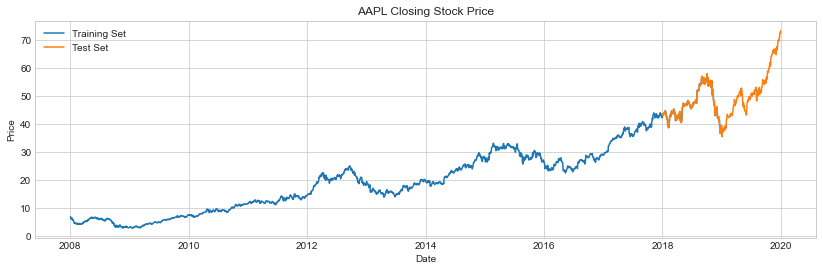

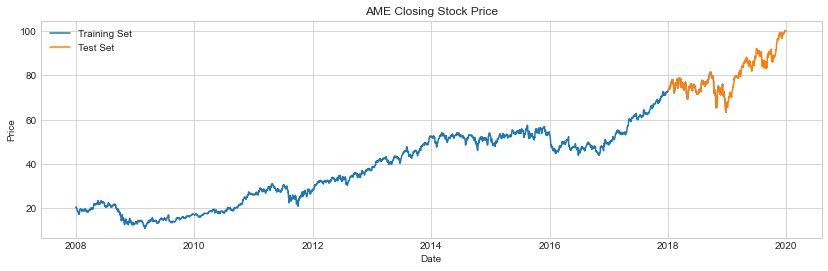

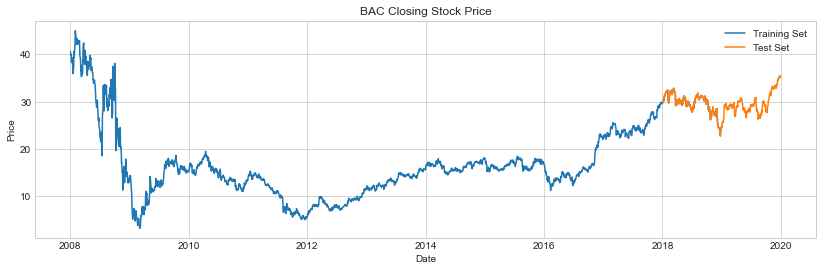

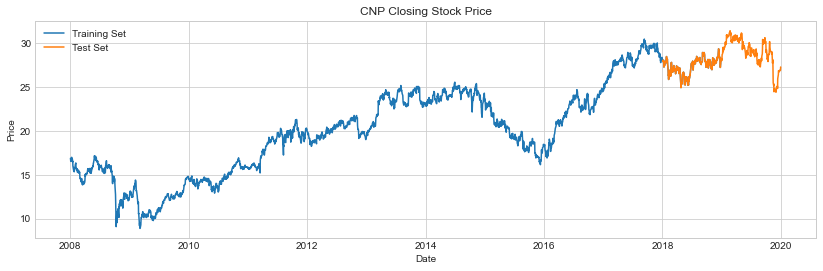

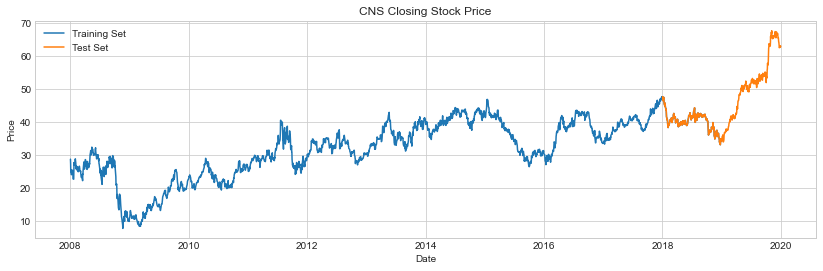

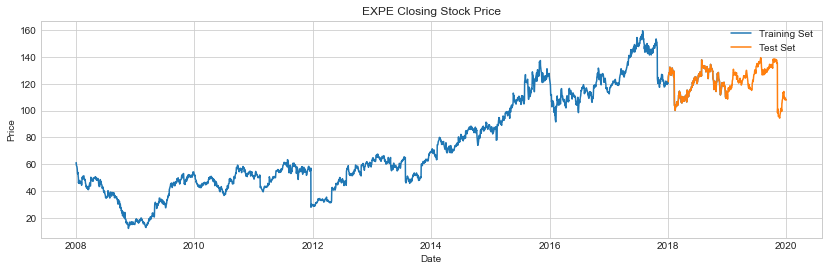

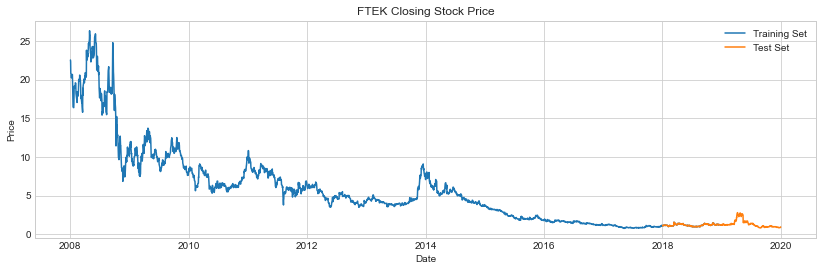

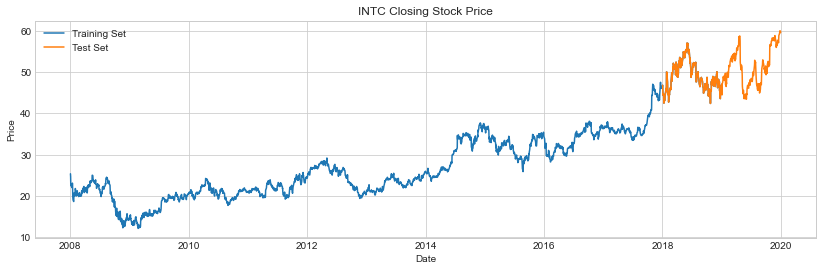

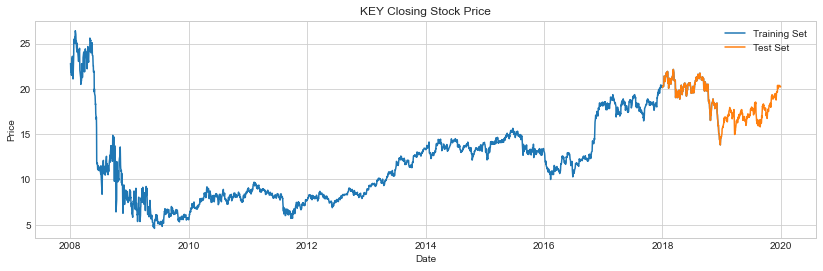

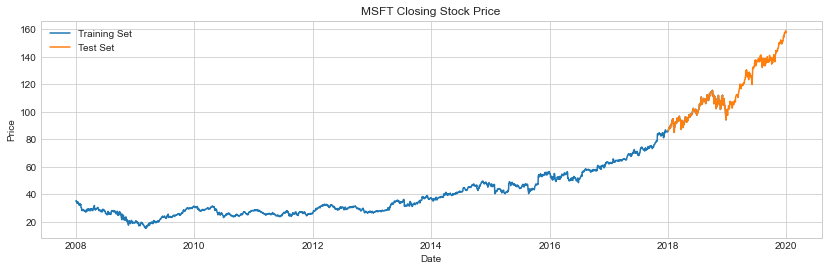

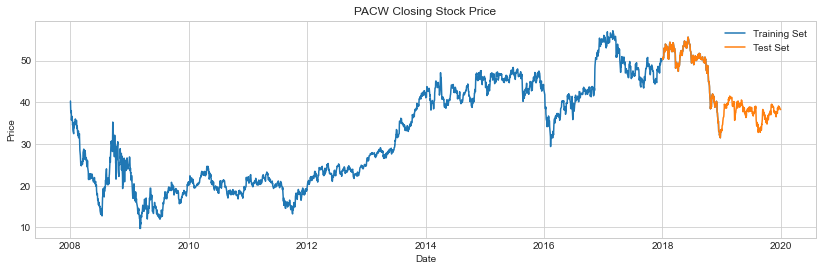

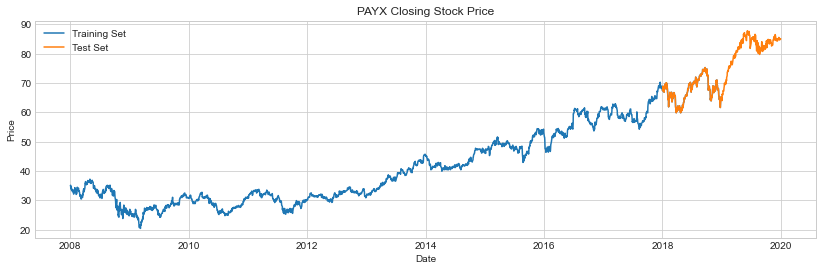

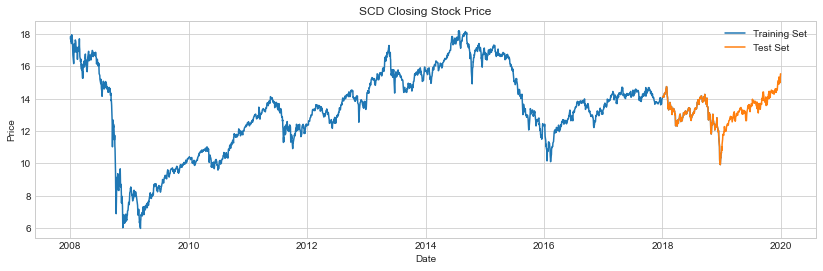

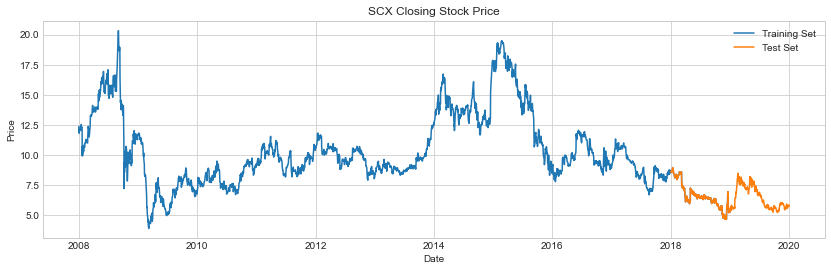

In [12]:
for i in tickers2:
    plt.figure(figsize=(14,4))
    plt.plot(df2_new[i]["Train"])
    plt.plot(df2_new[i]["Test"])
    plt.ylabel("Price")
    plt.xlabel("Date")
    plt.legend(["Training Set", "Test Set"])
    plt.title(i + " Closing Stock Price")

### RNN: LSTM

Para la aplicación de las Redes Neuronales Recurrentes de tipo LSTM, es necesario rescalar y homogenizar los datos. Dado que cada empresa tiene su propia escala, se reescalan considerando el precio más alto 1 y el precio más bajo 0. 

Para ello se realizan dos diccionarios que contienen los precios escalados para cada empresa, uno contiene el juego de entrenamiento y otro el de prueba. 

Asimismo, se realiza un tercer diccionario que contenga el escalar, de esta forma será útil cuando en un futuro se requiera realizar una transformación inversa de la predicción.

In [13]:
# Scaling the training set
transform_train = {}
transform_test = {}
scaler = {}

for num, i in enumerate(tickers2):
    sc = MinMaxScaler(feature_range=(0,1))
    a0 = np.array(df2_new[i]["Train"])
    a1 = np.array(df2_new[i]["Test"])
    a0 = a0.reshape(a0.shape[0],1)
    a1 = a1.reshape(a1.shape[0],1)
    transform_train[i] = sc.fit_transform(a0)
    transform_test[i] = sc.fit_transform(a1)
    scaler[i] = sc
    
del a0
del a1


Imprimimos la transformación para cada empresa. En general, todas las empresas tienen el mismo número de datos, ya que se eligieron de tal manera que contaran con los datos para poder llegar a este punto. Es necesario tener la información uniforme, para la aplicación de la RNN. 

In [14]:
for i in transform_train.keys():
    print(i, transform_train[i].shape)
print("\n")    
for i in transform_test.keys():
    print(i, transform_test[i].shape)

AAPL (2769, 1)
AME (2769, 1)
BAC (2769, 1)
CNP (2769, 1)
CNS (2769, 1)
EXPE (2769, 1)
FTEK (2769, 1)
INTC (2769, 1)
KEY (2769, 1)
MSFT (2769, 1)
PACW (2769, 1)
PAYX (2769, 1)
SCD (2769, 1)
SCX (2767, 1)


AAPL (503, 1)
AME (503, 1)
BAC (503, 1)
CNP (503, 1)
CNS (503, 1)
EXPE (503, 1)
FTEK (503, 1)
INTC (503, 1)
KEY (503, 1)
MSFT (503, 1)
PACW (503, 1)
PAYX (503, 1)
SCD (503, 1)
SCX (503, 1)


Se prepara la configuración de la información para las pruebas de entrenamiento y prueba para la entrada en la Red Neuronal.

In [15]:
trainset = {}
testset = {}
for j in tickers2:
    trainset[j] = {}
    X_train = []
    y_train = []
    for i in range(1,2767):
        X_train.append(transform_train[j][i-1:i,0])
        y_train.append(transform_train[j][i,0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    trainset[j]["X"] = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
    trainset[j]["y"] = y_train

    testset[j] = {}
    X_test = []
    y_test = []    
    for i in range(1, 503):
        X_test.append(transform_test[j][i-1:i,0])
        y_test.append(transform_test[j][i,0])
    X_test, y_test = np.array(X_test), np.array(y_test)
    testset[j]["X"] = np.reshape(X_test, (X_test.shape[0], X_train.shape[1], 1))
    testset[j]["y"] = y_test

Revisamos nuevamente la forma de los datos de entrenamiento y prueba previo a la aplicación de la red 

In [16]:
arr_buff = []
for i in tickers2:
    buff = {}
    buff["X_train"] = trainset[i]["X"].shape
    buff["y_train"] = trainset[i]["y"].shape
    buff["X_test"] = testset[i]["X"].shape
    buff["y_test"] = testset[i]["y"].shape
    arr_buff.append(buff)

pd.DataFrame(arr_buff, index=tickers2)

,X_train,y_train,X_test,y_test
AAPL,"(2766, 1, 1)","(2766,)","(502, 1, 1)","(502,)"
AME,"(2766, 1, 1)","(2766,)","(502, 1, 1)","(502,)"
BAC,"(2766, 1, 1)","(2766,)","(502, 1, 1)","(502,)"
CNP,"(2766, 1, 1)","(2766,)","(502, 1, 1)","(502,)"
CNS,"(2766, 1, 1)","(2766,)","(502, 1, 1)","(502,)"
EXPE,"(2766, 1, 1)","(2766,)","(502, 1, 1)","(502,)"
FTEK,"(2766, 1, 1)","(2766,)","(502, 1, 1)","(502,)"
INTC,"(2766, 1, 1)","(2766,)","(502, 1, 1)","(502,)"
KEY,"(2766, 1, 1)","(2766,)","(502, 1, 1)","(502,)"
MSFT,"(2766, 1, 1)","(2766,)","(502, 1, 1)","(502,)"


**Arquitectura de la Red Neuronal**

Para la red se consideró un Regressor Sequencial. La primer capa considera una dimensionalidad de salida de 50 unidades. el return_sequences debe ser true para pliar las capas, y es entrada de la siguiente capa. El input_shape es la forma de entrenamiento del conjunto de datos.

Un dropout de 0.20, significa que se eliminarán el 20% de las capas. Mientras que la capa Dense específica una salida de una unidad. 

Para copilar el modelo utilizamos RMS, con una función de pérdida de mínimos cuadrados ordinarios. Se consideraron 15 epochs y un batch size de 200. 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 50)             10400     
_________________________________________________________________
dropout (Dropout)            (None, 1, 50)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________
Fitting to AAPL
Epoch 1/13
19/19 [==============================] - 1s 50ms/step - loss: 0.0272 - accuracy: 3.6153e-04

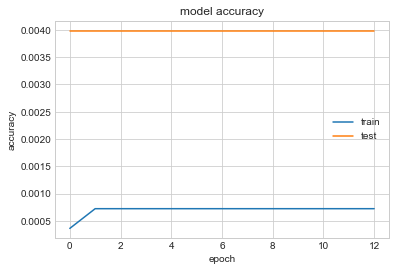

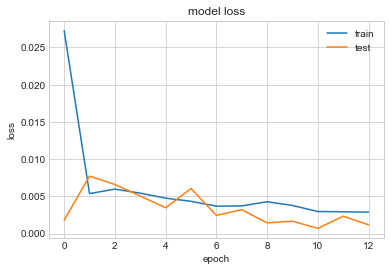

Fitting to AME
Epoch 1/13
19/19 [==============================] - 0s 7ms/step - loss: 0.0050 - accuracy: 7.2307e-04 - val_loss: 0.0024 - val_accuracy: 0.0040
Epoch 2/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0037 - accuracy: 7.2307e-04 - val_loss: 0.0029 - val_accuracy: 0.0040
Epoch 3/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0036 - accuracy: 7.2307e-04 - val_loss: 0.0062 - val_accuracy: 0.0040
Epoch 4/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0038 - accuracy: 7.2307e-04 - val_loss: 0.0016 - val_accuracy: 0.0040
Epoch 5/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0027 - accuracy: 7.2307e-04 - val_loss: 0.0013 - val_accuracy: 0.0040
Epoch 6/13
19/19 [==============================] - 0s 6ms/step - loss: 0.0032 - accuracy: 7.2307e-04 - val_loss: 0.0024 - val_accuracy: 0.0040
Epoch 7/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0033 - accuracy: 7.2307e-04 - val_loss: 8.6302e

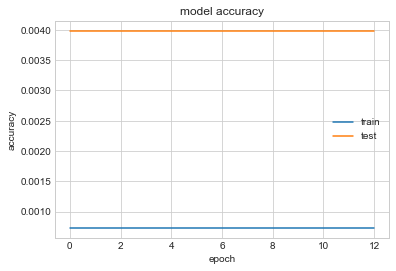

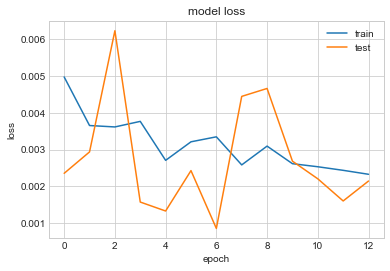

Fitting to BAC
Epoch 1/13
19/19 [==============================] - 0s 6ms/step - loss: 0.0016 - accuracy: 7.2307e-04 - val_loss: 0.0031 - val_accuracy: 0.0040
Epoch 2/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0019 - accuracy: 7.2307e-04 - val_loss: 0.0029 - val_accuracy: 0.0040
Epoch 3/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0015 - accuracy: 7.2307e-04 - val_loss: 0.0026 - val_accuracy: 0.0040
Epoch 4/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0015 - accuracy: 7.2307e-04 - val_loss: 0.0021 - val_accuracy: 0.0040
Epoch 5/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0014 - accuracy: 7.2307e-04 - val_loss: 0.0071 - val_accuracy: 0.0040
Epoch 6/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0017 - accuracy: 7.2307e-04 - val_loss: 0.0019 - val_accuracy: 0.0040
Epoch 7/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0014 - accuracy: 7.2307e-04 - val_loss: 0.0022 

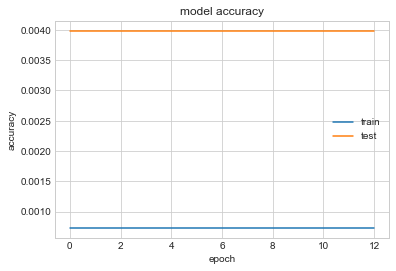

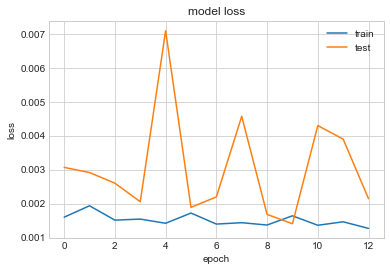

Fitting to CNP
Epoch 1/13
19/19 [==============================] - 0s 6ms/step - loss: 0.0036 - accuracy: 7.2307e-04 - val_loss: 0.0070 - val_accuracy: 0.0040
Epoch 2/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0028 - accuracy: 7.2307e-04 - val_loss: 0.0024 - val_accuracy: 0.0040
Epoch 3/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0024 - accuracy: 7.2307e-04 - val_loss: 0.0026 - val_accuracy: 0.0040
Epoch 4/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0027 - accuracy: 7.2307e-04 - val_loss: 0.0035 - val_accuracy: 0.0040
Epoch 5/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0024 - accuracy: 7.2307e-04 - val_loss: 0.0031 - val_accuracy: 0.0040
Epoch 6/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0020 - accuracy: 7.2307e-04 - val_loss: 0.0024 - val_accuracy: 0.0040
Epoch 7/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0023 - accuracy: 7.2307e-04 - val_loss: 0.0032 

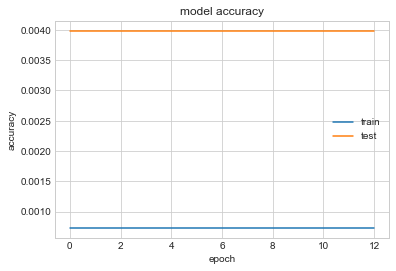

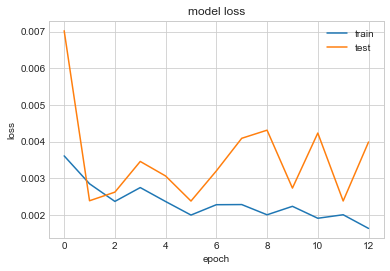

Fitting to CNS
Epoch 1/13
19/19 [==============================] - 0s 6ms/step - loss: 0.0027 - accuracy: 0.0011 - val_loss: 0.0011 - val_accuracy: 0.0040
Epoch 2/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0019 - accuracy: 0.0011 - val_loss: 5.3599e-04 - val_accuracy: 0.0040
Epoch 3/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0020 - accuracy: 0.0011 - val_loss: 0.0010 - val_accuracy: 0.0040
Epoch 4/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0019 - accuracy: 0.0011 - val_loss: 0.0015 - val_accuracy: 0.0040
Epoch 5/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0022 - accuracy: 0.0011 - val_loss: 0.0015 - val_accuracy: 0.0040
Epoch 6/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0018 - accuracy: 0.0011 - val_loss: 6.9265e-04 - val_accuracy: 0.0040
Epoch 7/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0018 - accuracy: 0.0011 - val_loss: 8.1199e-04 - val_accuracy: 

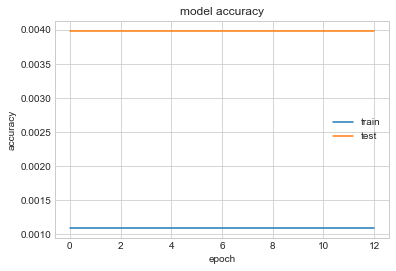

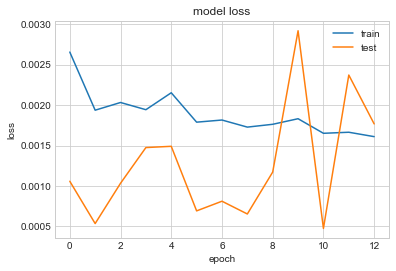

Fitting to EXPE
Epoch 1/13
19/19 [==============================] - 0s 6ms/step - loss: 0.0032 - accuracy: 7.2307e-04 - val_loss: 0.0037 - val_accuracy: 0.0040
Epoch 2/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0024 - accuracy: 7.2307e-04 - val_loss: 0.0036 - val_accuracy: 0.0040
Epoch 3/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0022 - accuracy: 7.2307e-04 - val_loss: 0.0037 - val_accuracy: 0.0040
Epoch 4/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0019 - accuracy: 7.2307e-04 - val_loss: 0.0035 - val_accuracy: 0.0040
Epoch 5/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0016 - accuracy: 7.2307e-04 - val_loss: 0.0040 - val_accuracy: 0.0040
Epoch 6/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0019 - accuracy: 7.2307e-04 - val_loss: 0.0034 - val_accuracy: 0.0040
Epoch 7/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0016 - accuracy: 7.2307e-04 - val_loss: 0.0038

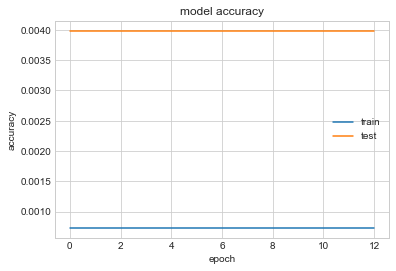

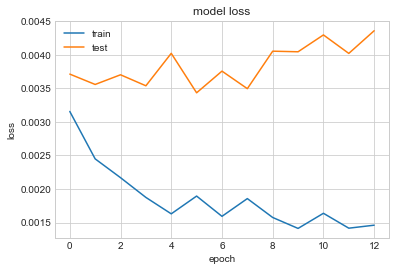

Fitting to FTEK
Epoch 1/13
19/19 [==============================] - 0s 7ms/step - loss: 0.0032 - accuracy: 0.0011 - val_loss: 0.0017 - val_accuracy: 0.0060
Epoch 2/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0022 - accuracy: 0.0011 - val_loss: 0.0020 - val_accuracy: 0.0060
Epoch 3/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0021 - accuracy: 0.0011 - val_loss: 0.0032 - val_accuracy: 0.0060
Epoch 4/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0020 - accuracy: 0.0011 - val_loss: 0.0025 - val_accuracy: 0.0060
Epoch 5/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0016 - accuracy: 0.0011 - val_loss: 0.0015 - val_accuracy: 0.0060
Epoch 6/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0018 - accuracy: 0.0011 - val_loss: 0.0023 - val_accuracy: 0.0060
Epoch 7/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0016 - accuracy: 0.0011 - val_loss: 0.0014 - val_accuracy: 0.0060
Epoc

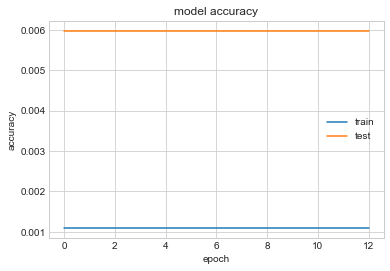

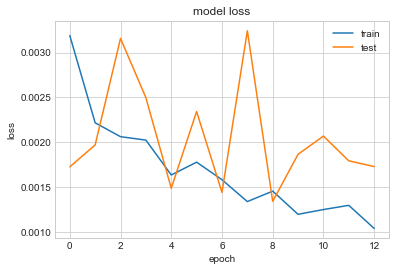

Fitting to INTC
Epoch 1/13
19/19 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 7.2307e-04 - val_loss: 0.0105 - val_accuracy: 0.0040
Epoch 2/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0018 - accuracy: 7.2307e-04 - val_loss: 0.0029 - val_accuracy: 0.0040
Epoch 3/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0014 - accuracy: 7.2307e-04 - val_loss: 0.0031 - val_accuracy: 0.0040
Epoch 4/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0011 - accuracy: 7.2307e-04 - val_loss: 0.0031 - val_accuracy: 0.0040
Epoch 5/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0012 - accuracy: 7.2307e-04 - val_loss: 0.0058 - val_accuracy: 0.0040
Epoch 6/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0010 - accuracy: 7.2307e-04 - val_loss: 0.0053 - val_accuracy: 0.0040
Epoch 7/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0013 - accuracy: 7.2307e-04 - val_loss: 0.0038

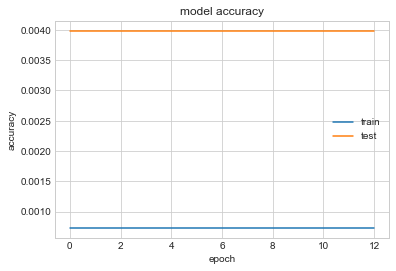

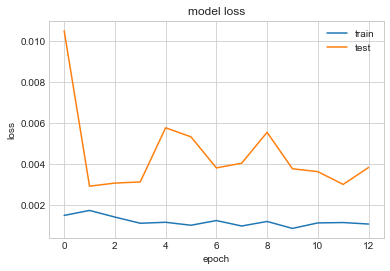

Fitting to KEY
Epoch 1/13
19/19 [==============================] - 0s 7ms/step - loss: 0.0012 - accuracy: 7.2307e-04 - val_loss: 0.0017 - val_accuracy: 0.0040
Epoch 2/13
19/19 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 4.7619e- - 0s 5ms/step - loss: 0.0013 - accuracy: 7.2307e-04 - val_loss: 0.0015 - val_accuracy: 0.0040
Epoch 3/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0013 - accuracy: 7.2307e-04 - val_loss: 0.0018 - val_accuracy: 0.0040
Epoch 4/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0013 - accuracy: 7.2307e-04 - val_loss: 0.0014 - val_accuracy: 0.0040
Epoch 5/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0012 - accuracy: 7.2307e-04 - val_loss: 0.0014 - val_accuracy: 0.0040
Epoch 6/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0014 - accuracy: 7.2307e-04 - val_loss: 0.0016 - val_accuracy: 0.0040
Epoch 7/13
19/19 [==============================] - 0s 6ms/step - loss: 0.0

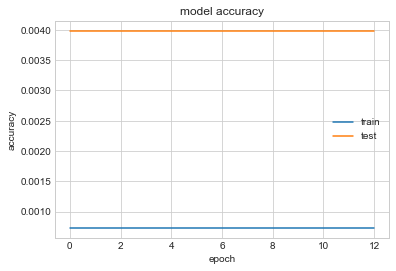

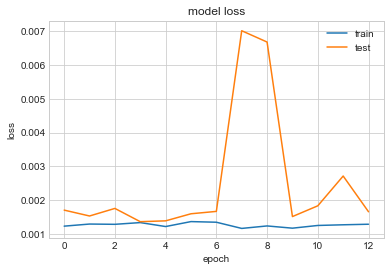

Fitting to MSFT
Epoch 1/13
19/19 [==============================] - 0s 6ms/step - loss: 0.0012 - accuracy: 7.2307e-04 - val_loss: 0.0015 - val_accuracy: 0.0040
Epoch 2/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0012 - accuracy: 7.2307e-04 - val_loss: 0.0022 - val_accuracy: 0.0040
Epoch 3/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0011 - accuracy: 7.2307e-04 - val_loss: 7.3285e-04 - val_accuracy: 0.0040
Epoch 4/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0011 - accuracy: 7.2307e-04 - val_loss: 0.0076 - val_accuracy: 0.0040
Epoch 5/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0010 - accuracy: 7.2307e-04 - val_loss: 0.0012 - val_accuracy: 0.0040
Epoch 6/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0010 - accuracy: 7.2307e-04 - val_loss: 0.0022 - val_accuracy: 0.0040
Epoch 7/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0012 - accuracy: 7.2307e-04 - val_loss: 6.

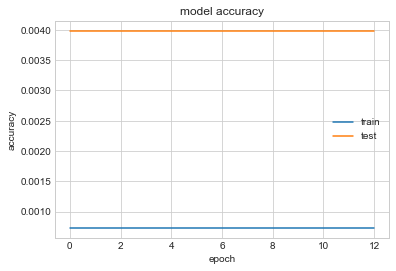

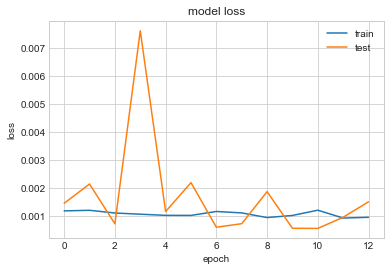

Fitting to PACW
Epoch 1/13
19/19 [==============================] - 0s 6ms/step - loss: 0.0024 - accuracy: 0.0011 - val_loss: 7.9887e-04 - val_accuracy: 0.0040
Epoch 2/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0027 - accuracy: 0.0011 - val_loss: 0.0034 - val_accuracy: 0.0040
Epoch 3/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0023 - accuracy: 0.0011 - val_loss: 0.0026 - val_accuracy: 0.0040
Epoch 4/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0018 - accuracy: 0.0011 - val_loss: 0.0032 - val_accuracy: 0.0040
Epoch 5/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0018 - accuracy: 0.0011 - val_loss: 9.9353e-04 - val_accuracy: 0.0040
Epoch 6/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0018 - accuracy: 0.0011 - val_loss: 0.0015 - val_accuracy: 0.0040
Epoch 7/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0020 - accuracy: 0.0011 - val_loss: 8.7533e-04 - val_accuracy:

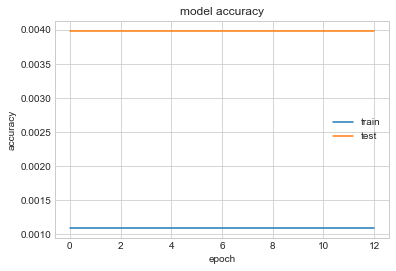

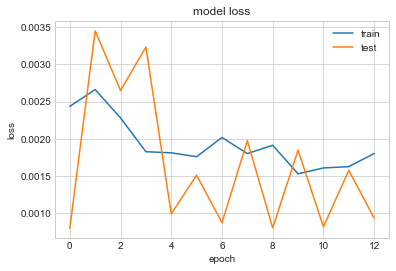

Fitting to PAYX
Epoch 1/13
19/19 [==============================] - 0s 7ms/step - loss: 0.0011 - accuracy: 7.2307e-04 - val_loss: 0.0016 - val_accuracy: 0.0040
Epoch 2/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0012 - accuracy: 7.2307e-04 - val_loss: 0.0012 - val_accuracy: 0.0040
Epoch 3/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0012 - accuracy: 7.2307e-04 - val_loss: 0.0015 - val_accuracy: 0.0040
Epoch 4/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0012 - accuracy: 7.2307e-04 - val_loss: 0.0023 - val_accuracy: 0.0040
Epoch 5/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0012 - accuracy: 7.2307e-04 - val_loss: 0.0014 - val_accuracy: 0.0040
Epoch 6/13
19/19 [==============================] - 0s 5ms/step - loss: 9.3903e-04 - accuracy: 7.2307e-04 - val_loss: 0.0015 - val_accuracy: 0.0040
Epoch 7/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0012 - accuracy: 7.2307e-04 - val_loss: 0.

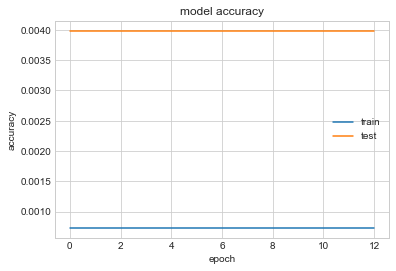

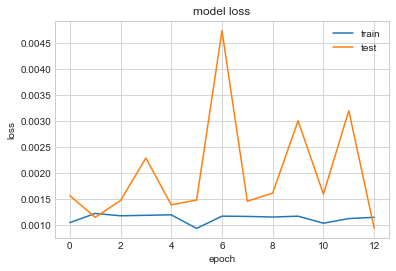

Fitting to SCD
Epoch 1/13
19/19 [==============================] - 0s 7ms/step - loss: 0.0018 - accuracy: 7.2307e-04 - val_loss: 0.0040 - val_accuracy: 0.0040
Epoch 2/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0018 - accuracy: 7.2307e-04 - val_loss: 9.4390e-04 - val_accuracy: 0.0040
Epoch 3/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0015 - accuracy: 7.2307e-04 - val_loss: 0.0016 - val_accuracy: 0.0040
Epoch 4/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0016 - accuracy: 7.2307e-04 - val_loss: 0.0010 - val_accuracy: 0.0040
Epoch 5/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0013 - accuracy: 7.2307e-04 - val_loss: 7.3874e-04 - val_accuracy: 0.0040
Epoch 6/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0012 - accuracy: 7.2307e-04 - val_loss: 0.0041 - val_accuracy: 0.0040
Epoch 7/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0016 - accuracy: 7.2307e-04 - val_loss:

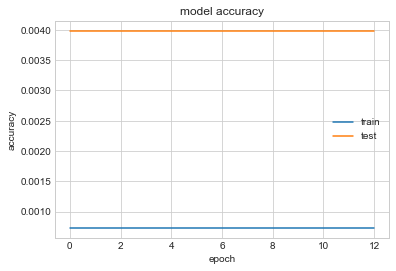

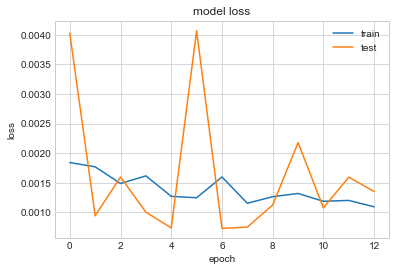

Fitting to SCX
Epoch 1/13
19/19 [==============================] - 0s 7ms/step - loss: 0.0017 - accuracy: 7.2307e-04 - val_loss: 0.0029 - val_accuracy: 0.0060
Epoch 2/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0013 - accuracy: 7.2307e-04 - val_loss: 0.0026 - val_accuracy: 0.0060
Epoch 3/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0015 - accuracy: 7.2307e-04 - val_loss: 0.0020 - val_accuracy: 0.0060
Epoch 4/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0013 - accuracy: 7.2307e-04 - val_loss: 0.0020 - val_accuracy: 0.0060
Epoch 5/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0012 - accuracy: 7.2307e-04 - val_loss: 0.0024 - val_accuracy: 0.0060
Epoch 6/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0013 - accuracy: 7.2307e-04 - val_loss: 0.0026 - val_accuracy: 0.0060
Epoch 7/13
19/19 [==============================] - 0s 5ms/step - loss: 0.0011 - accuracy: 7.2307e-04 - val_loss: 0.0023 

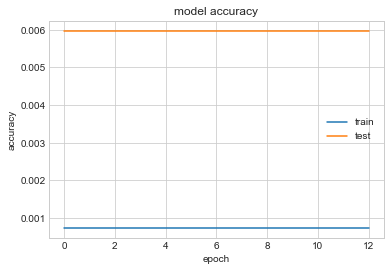

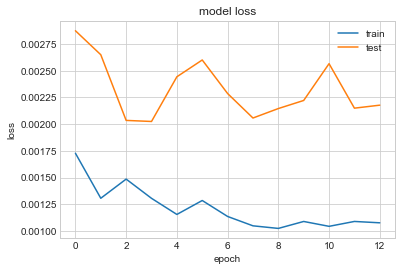

In [21]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.10))
# Second LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.20))
# The output layer
regressor.add(Dense(units=1))
 
opt = tf.keras.optimizers.RMSprop(learning_rate=0.01)
 
# Compiling the RNN
regressor.compile(optimizer=opt, loss='mean_squared_error', metrics=['accuracy'])
 
regressor.summary()
 
# Fitting to the training set
for i in tickers2:
    print("Fitting to", i)
    results = regressor.fit(trainset[i]["X"], trainset[i]["y"], epochs=13, batch_size=150, validation_data=(testset[i]["X"], testset[i]["y"]))
    
    # evaluate the keras model
    _, accuracy = regressor.evaluate(trainset[i]["X"], trainset[i]["y"])
    print('Accuracy: %.2f' % (accuracy*100))
    
    # summarize history for accuracy
    plt.plot(results.history['accuracy'])
    plt.plot(results.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'])
    plt.show()
    
    # summarize history for loss
    plt.plot(results.history['loss'])
    plt.plot(results.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'])
    plt.show()

Realizamos la predicción para el conjunto de prueba y la graficamos con los datos reales de las acciones. Para ello requerimos el escalar y la transformación inversa para poder convertir las salidas de información. 

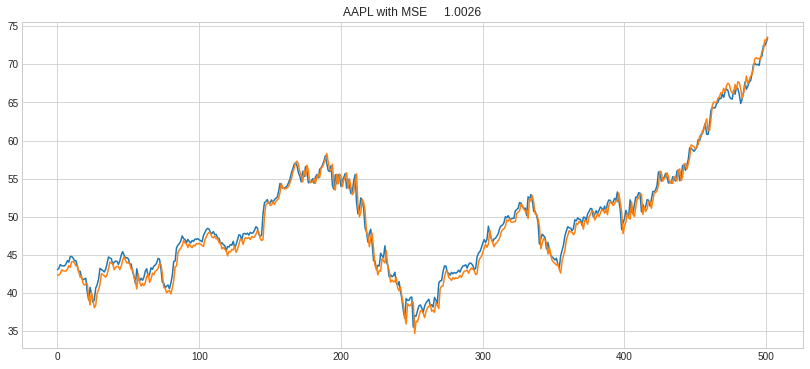

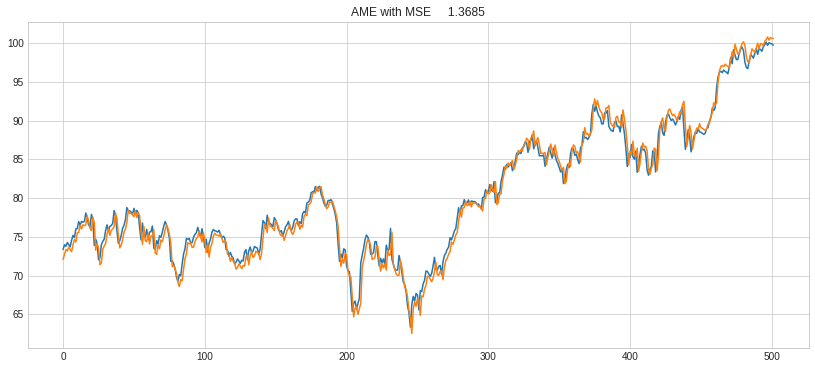

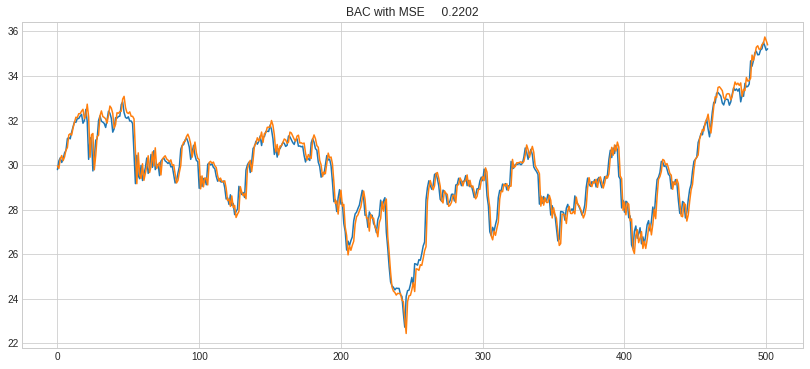

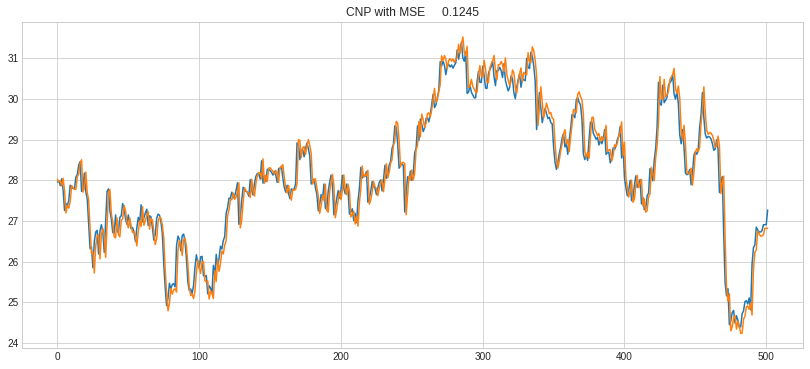

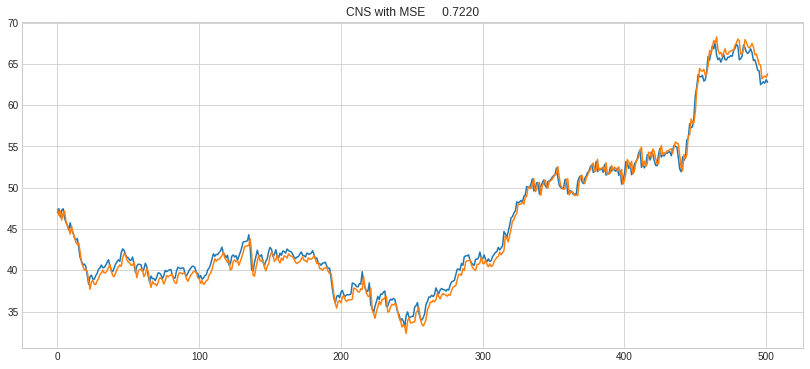

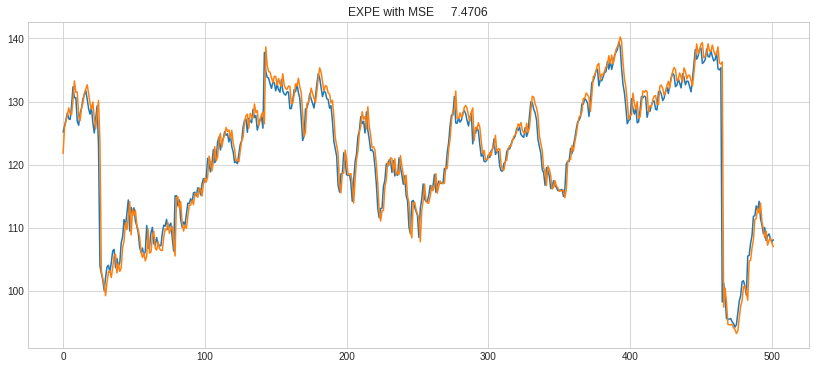

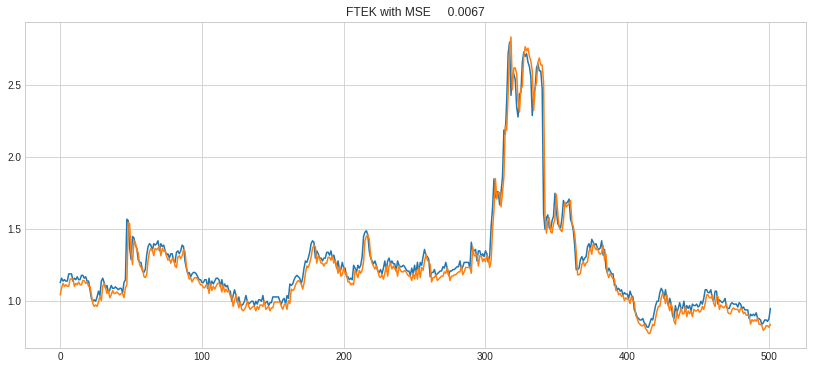

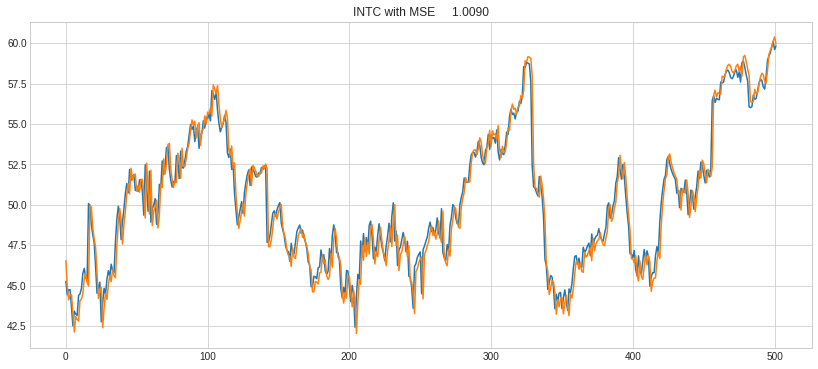

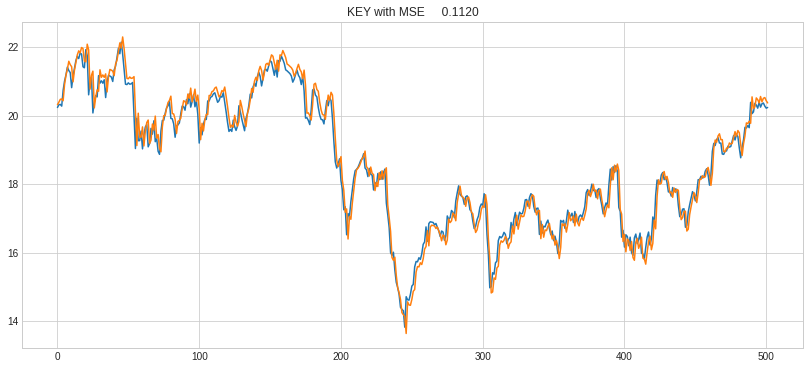

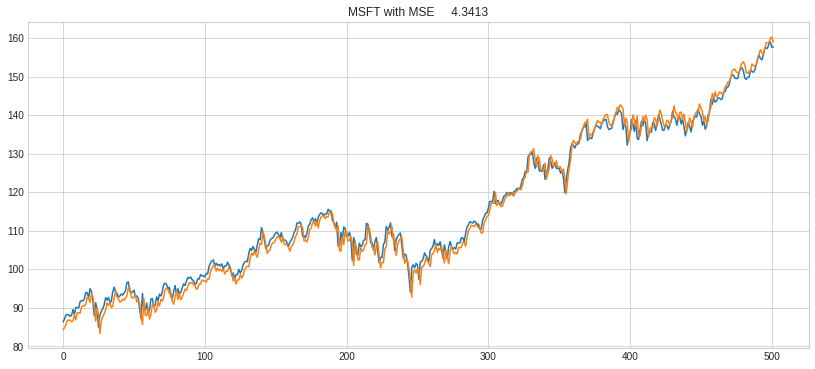

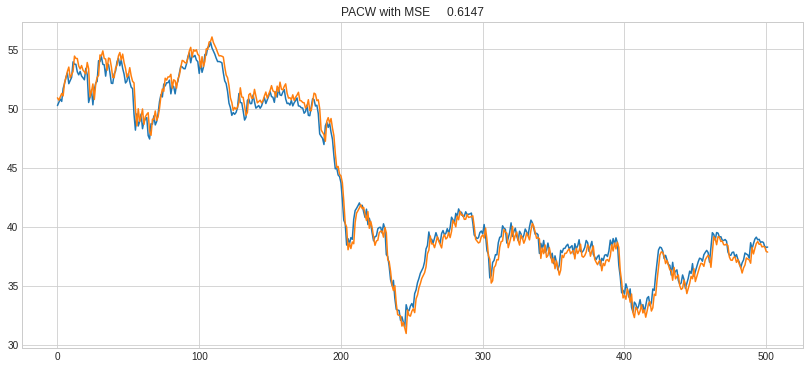

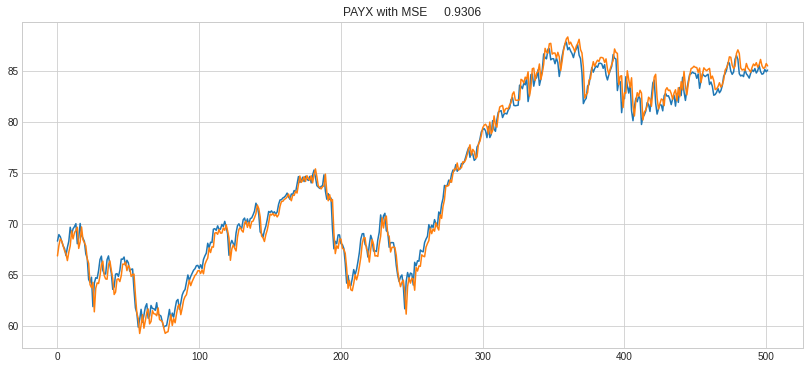

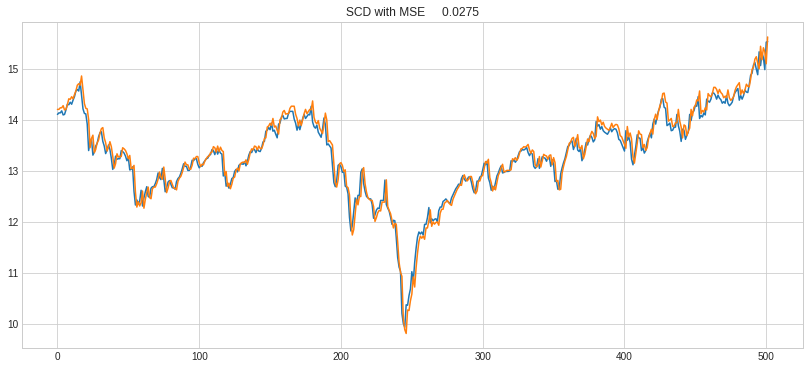

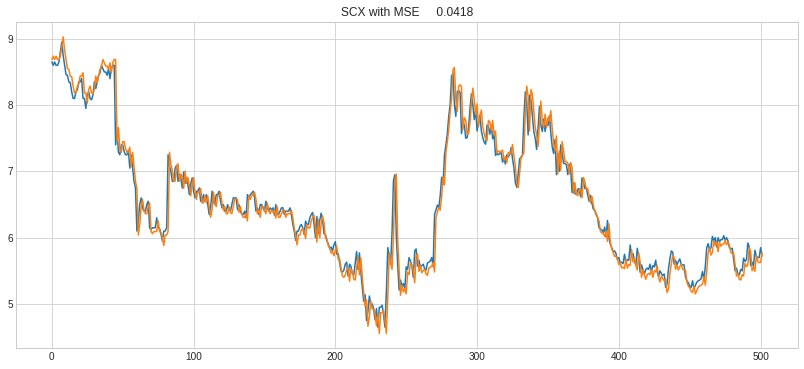

In [ ]:
pred_result = {}
for i in tickers2:
    y_true = scaler[i].inverse_transform(testset[i]["y"].reshape(-1,1))
    y_pred = scaler[i].inverse_transform(regressor.predict(testset[i]["X"]))
    MSE = mean_squared_error(y_true, y_pred)
    pred_result[i] = {}
    pred_result[i]["True"] = y_true
    pred_result[i]["Pred"] = y_pred
    pred = pd.DataFrame(y_pred, columns=['Pred_'+i])
    true = pd.DataFrame(y_true, columns=['True_'+i])
    result = pd.concat([pred, true], axis=1)
    result = result.to_csv('results_pred_'+i+'.csv')
    plt.figure(figsize=(14,6))
    plt.title("{} with MSE {:10.4f}".format(i,MSE))
    plt.plot(y_true, label='Real')
    plt.plot(y_pred, label='Predicción')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1, 50)             10400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 50)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 50)             20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 50)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 50)             20200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 50)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)               

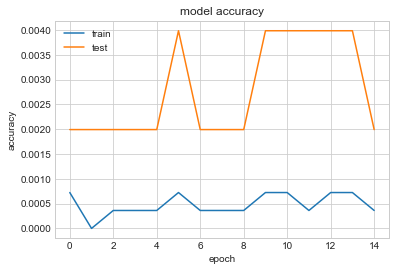

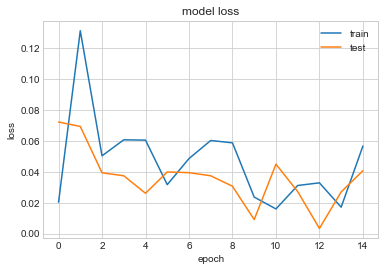

Fitting to AME
Epoch 1/15
14/14 - 0s - loss: 0.0458 - accuracy: 7.2307e-04 - val_loss: 0.0342 - val_accuracy: 0.0040
Epoch 2/15
14/14 - 0s - loss: 0.0368 - accuracy: 7.2307e-04 - val_loss: 0.0102 - val_accuracy: 0.0040
Epoch 3/15
14/14 - 0s - loss: 0.0106 - accuracy: 7.2307e-04 - val_loss: 0.0029 - val_accuracy: 0.0040
Epoch 4/15
14/14 - 0s - loss: 0.0106 - accuracy: 7.2307e-04 - val_loss: 0.0017 - val_accuracy: 0.0040
Epoch 5/15
14/14 - 0s - loss: 0.0097 - accuracy: 7.2307e-04 - val_loss: 0.0126 - val_accuracy: 0.0040
Epoch 6/15
14/14 - 0s - loss: 0.0087 - accuracy: 7.2307e-04 - val_loss: 0.0026 - val_accuracy: 0.0040
Epoch 7/15
14/14 - 0s - loss: 0.0091 - accuracy: 7.2307e-04 - val_loss: 0.0018 - val_accuracy: 0.0040
Epoch 8/15
14/14 - 0s - loss: 0.0070 - accuracy: 7.2307e-04 - val_loss: 0.0026 - val_accuracy: 0.0040
Epoch 9/15
14/14 - 0s - loss: 0.0072 - accuracy: 7.2307e-04 - val_loss: 0.0050 - val_accuracy: 0.0040
Epoch 10/15
14/14 - 0s - loss: 0.0066 - accuracy: 7.2307e-04 - val_

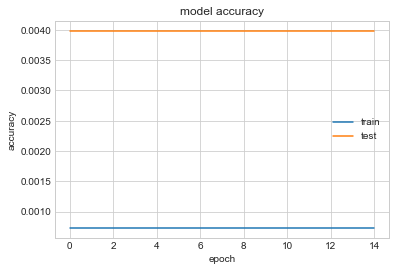

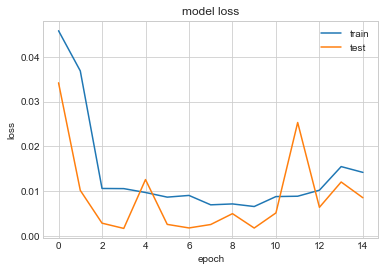

Fitting to BAC
Epoch 1/15
14/14 - 0s - loss: 0.0114 - accuracy: 7.2307e-04 - val_loss: 0.0110 - val_accuracy: 0.0040
Epoch 2/15
14/14 - 0s - loss: 0.0103 - accuracy: 7.2307e-04 - val_loss: 0.0056 - val_accuracy: 0.0040
Epoch 3/15
14/14 - 0s - loss: 0.0195 - accuracy: 7.2307e-04 - val_loss: 0.0520 - val_accuracy: 0.0020
Epoch 4/15
14/14 - 0s - loss: 0.0225 - accuracy: 3.6153e-04 - val_loss: 0.0200 - val_accuracy: 0.0040
Epoch 5/15
14/14 - 0s - loss: 0.0114 - accuracy: 7.2307e-04 - val_loss: 0.0033 - val_accuracy: 0.0040
Epoch 6/15
14/14 - 0s - loss: 0.0058 - accuracy: 7.2307e-04 - val_loss: 0.0038 - val_accuracy: 0.0040
Epoch 7/15
14/14 - 0s - loss: 0.0052 - accuracy: 7.2307e-04 - val_loss: 0.0036 - val_accuracy: 0.0040
Epoch 8/15
14/14 - 0s - loss: 0.0056 - accuracy: 7.2307e-04 - val_loss: 0.0024 - val_accuracy: 0.0040
Epoch 9/15
14/14 - 0s - loss: 0.0054 - accuracy: 7.2307e-04 - val_loss: 0.0101 - val_accuracy: 0.0040
Epoch 10/15
14/14 - 0s - loss: 0.0085 - accuracy: 7.2307e-04 - val_

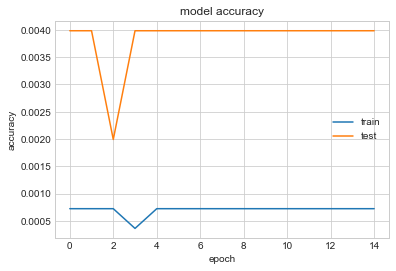

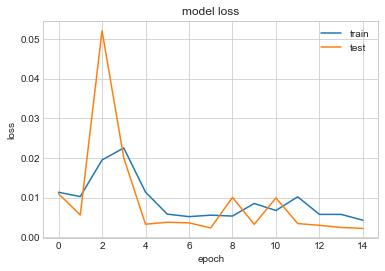

Fitting to CNP
Epoch 1/15
14/14 - 0s - loss: 0.0072 - accuracy: 7.2307e-04 - val_loss: 0.0117 - val_accuracy: 0.0040
Epoch 2/15
14/14 - 0s - loss: 0.0239 - accuracy: 7.2307e-04 - val_loss: 0.0072 - val_accuracy: 0.0040
Epoch 3/15
14/14 - 0s - loss: 0.0382 - accuracy: 7.2307e-04 - val_loss: 0.0290 - val_accuracy: 0.0040
Epoch 4/15
14/14 - 0s - loss: 0.0078 - accuracy: 7.2307e-04 - val_loss: 0.0086 - val_accuracy: 0.0040
Epoch 5/15
14/14 - 0s - loss: 0.0147 - accuracy: 7.2307e-04 - val_loss: 0.0068 - val_accuracy: 0.0040
Epoch 6/15
14/14 - 0s - loss: 0.0057 - accuracy: 7.2307e-04 - val_loss: 0.0049 - val_accuracy: 0.0040
Epoch 7/15
14/14 - 0s - loss: 0.0074 - accuracy: 7.2307e-04 - val_loss: 0.0053 - val_accuracy: 0.0040
Epoch 8/15
14/14 - 0s - loss: 0.0058 - accuracy: 7.2307e-04 - val_loss: 0.0063 - val_accuracy: 0.0040
Epoch 9/15
14/14 - 0s - loss: 0.0090 - accuracy: 7.2307e-04 - val_loss: 0.0086 - val_accuracy: 0.0040
Epoch 10/15
14/14 - 0s - loss: 0.0065 - accuracy: 7.2307e-04 - val_

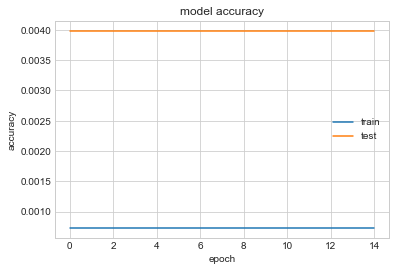

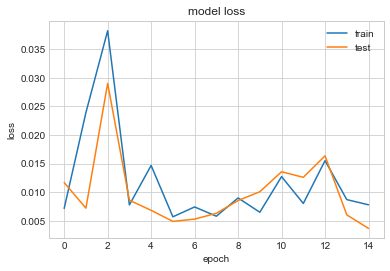

Fitting to CNS
Epoch 1/15
14/14 - 0s - loss: 0.0061 - accuracy: 0.0011 - val_loss: 0.0022 - val_accuracy: 0.0040
Epoch 2/15
14/14 - 0s - loss: 0.0049 - accuracy: 0.0011 - val_loss: 0.0017 - val_accuracy: 0.0040
Epoch 3/15
14/14 - 0s - loss: 0.0044 - accuracy: 0.0011 - val_loss: 0.0013 - val_accuracy: 0.0040
Epoch 4/15
14/14 - 0s - loss: 0.0042 - accuracy: 0.0011 - val_loss: 0.0012 - val_accuracy: 0.0040
Epoch 5/15
14/14 - 0s - loss: 0.0043 - accuracy: 0.0011 - val_loss: 0.0014 - val_accuracy: 0.0040
Epoch 6/15
14/14 - 0s - loss: 0.0039 - accuracy: 0.0011 - val_loss: 0.0016 - val_accuracy: 0.0040
Epoch 7/15
14/14 - 0s - loss: 0.0041 - accuracy: 0.0011 - val_loss: 0.0011 - val_accuracy: 0.0040
Epoch 8/15
14/14 - 0s - loss: 0.0040 - accuracy: 0.0011 - val_loss: 0.0018 - val_accuracy: 0.0040
Epoch 9/15
14/14 - 0s - loss: 0.0041 - accuracy: 0.0011 - val_loss: 0.0012 - val_accuracy: 0.0040
Epoch 10/15
14/14 - 0s - loss: 0.0044 - accuracy: 0.0011 - val_loss: 0.0030 - val_accuracy: 0.0040
Epoc

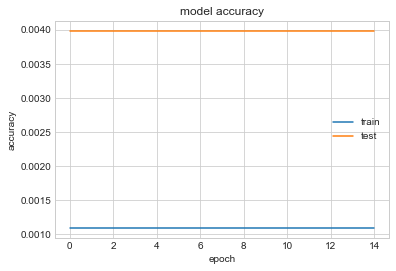

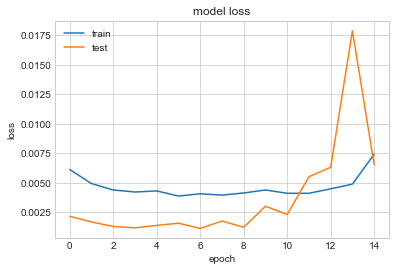

Fitting to EXPE
Epoch 1/15
14/14 - 0s - loss: 0.0058 - accuracy: 7.2307e-04 - val_loss: 0.0082 - val_accuracy: 0.0040
Epoch 2/15
14/14 - 0s - loss: 0.0148 - accuracy: 7.2307e-04 - val_loss: 0.0205 - val_accuracy: 0.0040
Epoch 3/15
14/14 - 0s - loss: 0.0175 - accuracy: 7.2307e-04 - val_loss: 0.0179 - val_accuracy: 0.0040
Epoch 4/15
14/14 - 0s - loss: 0.0273 - accuracy: 7.2307e-04 - val_loss: 0.0396 - val_accuracy: 0.0040
Epoch 5/15
14/14 - 0s - loss: 0.0457 - accuracy: 7.2307e-04 - val_loss: 0.0126 - val_accuracy: 0.0040
Epoch 6/15
14/14 - 0s - loss: 0.0472 - accuracy: 7.2307e-04 - val_loss: 0.0308 - val_accuracy: 0.0040
Epoch 7/15
14/14 - 0s - loss: 0.0250 - accuracy: 7.2307e-04 - val_loss: 0.0101 - val_accuracy: 0.0040
Epoch 8/15
14/14 - 0s - loss: 0.0641 - accuracy: 3.6153e-04 - val_loss: 0.1213 - val_accuracy: 0.0020
Epoch 9/15
14/14 - 0s - loss: 0.0668 - accuracy: 3.6153e-04 - val_loss: 0.0892 - val_accuracy: 0.0020
Epoch 10/15
14/14 - 0s - loss: 0.0421 - accuracy: 3.6153e-04 - val

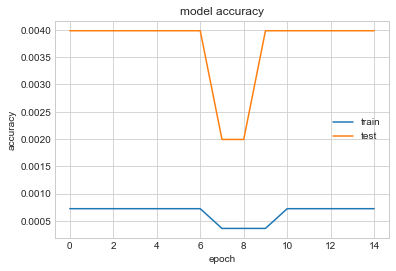

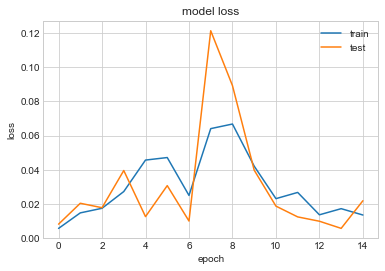

Fitting to FTEK
Epoch 1/15
14/14 - 0s - loss: 0.0161 - accuracy: 0.0011 - val_loss: 0.0133 - val_accuracy: 0.0060
Epoch 2/15
14/14 - 0s - loss: 0.0228 - accuracy: 0.0011 - val_loss: 0.0035 - val_accuracy: 0.0060
Epoch 3/15
14/14 - 0s - loss: 0.0102 - accuracy: 0.0011 - val_loss: 0.0084 - val_accuracy: 0.0060
Epoch 4/15
14/14 - 0s - loss: 0.0120 - accuracy: 0.0011 - val_loss: 0.0047 - val_accuracy: 0.0060
Epoch 5/15
14/14 - 0s - loss: 0.0112 - accuracy: 0.0011 - val_loss: 0.0040 - val_accuracy: 0.0060
Epoch 6/15
14/14 - 0s - loss: 0.0060 - accuracy: 0.0011 - val_loss: 0.0026 - val_accuracy: 0.0060
Epoch 7/15
14/14 - 0s - loss: 0.0052 - accuracy: 0.0011 - val_loss: 0.0020 - val_accuracy: 0.0060
Epoch 8/15
14/14 - 0s - loss: 0.0052 - accuracy: 0.0011 - val_loss: 0.0035 - val_accuracy: 0.0060
Epoch 9/15
14/14 - 0s - loss: 0.0050 - accuracy: 0.0011 - val_loss: 0.0017 - val_accuracy: 0.0060
Epoch 10/15
14/14 - 0s - loss: 0.0055 - accuracy: 0.0011 - val_loss: 0.0046 - val_accuracy: 0.0060
Epo

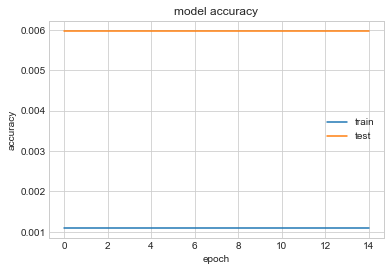

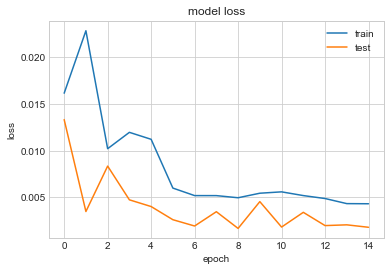

Fitting to INTC
Epoch 1/15
14/14 - 0s - loss: 0.0056 - accuracy: 7.2307e-04 - val_loss: 0.0047 - val_accuracy: 0.0040
Epoch 2/15
14/14 - 0s - loss: 0.0055 - accuracy: 7.2307e-04 - val_loss: 0.0061 - val_accuracy: 0.0040
Epoch 3/15
14/14 - 0s - loss: 0.0060 - accuracy: 7.2307e-04 - val_loss: 0.0068 - val_accuracy: 0.0040
Epoch 4/15
14/14 - 0s - loss: 0.0095 - accuracy: 7.2307e-04 - val_loss: 0.0227 - val_accuracy: 0.0040
Epoch 5/15
14/14 - 0s - loss: 0.0326 - accuracy: 3.6153e-04 - val_loss: 0.0308 - val_accuracy: 0.0040
Epoch 6/15
14/14 - 0s - loss: 0.0189 - accuracy: 7.2307e-04 - val_loss: 0.0124 - val_accuracy: 0.0040
Epoch 7/15
14/14 - 0s - loss: 0.0089 - accuracy: 7.2307e-04 - val_loss: 0.0067 - val_accuracy: 0.0040
Epoch 8/15
14/14 - 0s - loss: 0.0077 - accuracy: 7.2307e-04 - val_loss: 0.0049 - val_accuracy: 0.0040
Epoch 9/15
14/14 - 0s - loss: 0.0070 - accuracy: 7.2307e-04 - val_loss: 0.0061 - val_accuracy: 0.0040
Epoch 10/15
14/14 - 0s - loss: 0.0084 - accuracy: 7.2307e-04 - val

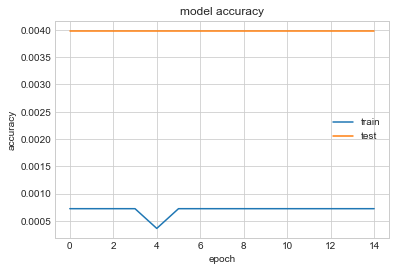

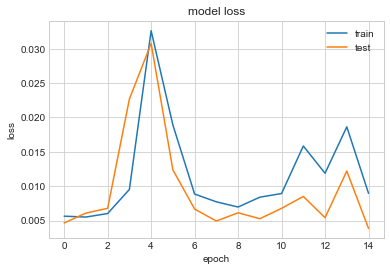

Fitting to KEY
Epoch 1/15
14/14 - 0s - loss: 0.0086 - accuracy: 7.2307e-04 - val_loss: 0.0103 - val_accuracy: 0.0040
Epoch 2/15
14/14 - 0s - loss: 0.0113 - accuracy: 7.2307e-04 - val_loss: 0.0031 - val_accuracy: 0.0040
Epoch 3/15
14/14 - 0s - loss: 0.0080 - accuracy: 7.2307e-04 - val_loss: 0.0135 - val_accuracy: 0.0040
Epoch 4/15
14/14 - 0s - loss: 0.0111 - accuracy: 7.2307e-04 - val_loss: 0.0040 - val_accuracy: 0.0040
Epoch 5/15
14/14 - 0s - loss: 0.0074 - accuracy: 7.2307e-04 - val_loss: 0.0057 - val_accuracy: 0.0040
Epoch 6/15
14/14 - 0s - loss: 0.0079 - accuracy: 7.2307e-04 - val_loss: 0.0044 - val_accuracy: 0.0040
Epoch 7/15
14/14 - 0s - loss: 0.0067 - accuracy: 7.2307e-04 - val_loss: 0.0061 - val_accuracy: 0.0040
Epoch 8/15
14/14 - 0s - loss: 0.0081 - accuracy: 7.2307e-04 - val_loss: 0.0040 - val_accuracy: 0.0040
Epoch 9/15
14/14 - 0s - loss: 0.0081 - accuracy: 7.2307e-04 - val_loss: 0.0086 - val_accuracy: 0.0040
Epoch 10/15
14/14 - 0s - loss: 0.0104 - accuracy: 7.2307e-04 - val_

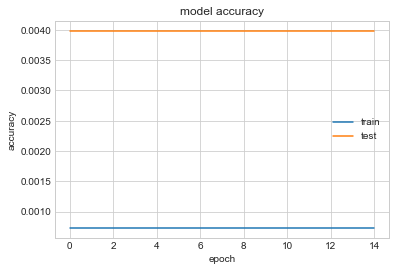

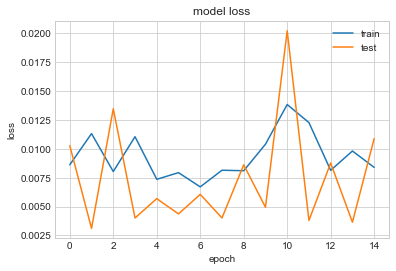

Fitting to MSFT
Epoch 1/15
14/14 - 0s - loss: 0.0083 - accuracy: 7.2307e-04 - val_loss: 0.0049 - val_accuracy: 0.0040
Epoch 2/15
14/14 - 0s - loss: 0.0054 - accuracy: 7.2307e-04 - val_loss: 0.0045 - val_accuracy: 0.0040
Epoch 3/15
14/14 - 0s - loss: 0.0107 - accuracy: 7.2307e-04 - val_loss: 0.0020 - val_accuracy: 0.0040
Epoch 4/15
14/14 - 0s - loss: 0.0161 - accuracy: 7.2307e-04 - val_loss: 0.0170 - val_accuracy: 0.0040
Epoch 5/15
14/14 - 0s - loss: 0.0069 - accuracy: 7.2307e-04 - val_loss: 0.0061 - val_accuracy: 0.0040
Epoch 6/15
14/14 - 0s - loss: 0.0077 - accuracy: 7.2307e-04 - val_loss: 0.0049 - val_accuracy: 0.0040
Epoch 7/15
14/14 - 0s - loss: 0.0109 - accuracy: 7.2307e-04 - val_loss: 0.0022 - val_accuracy: 0.0040
Epoch 8/15
14/14 - 0s - loss: 0.0065 - accuracy: 7.2307e-04 - val_loss: 0.0018 - val_accuracy: 0.0040
Epoch 9/15
14/14 - 0s - loss: 0.0068 - accuracy: 7.2307e-04 - val_loss: 0.0027 - val_accuracy: 0.0040
Epoch 10/15
14/14 - 0s - loss: 0.0144 - accuracy: 7.2307e-04 - val

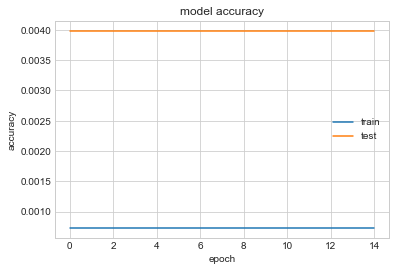

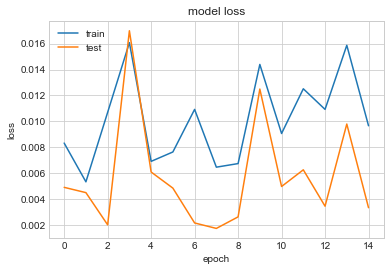

Fitting to PACW
Epoch 1/15
14/14 - 0s - loss: 0.0131 - accuracy: 0.0011 - val_loss: 0.0028 - val_accuracy: 0.0040
Epoch 2/15
14/14 - 0s - loss: 0.0258 - accuracy: 0.0011 - val_loss: 0.0283 - val_accuracy: 0.0040
Epoch 3/15
14/14 - 0s - loss: 0.0213 - accuracy: 0.0011 - val_loss: 0.0082 - val_accuracy: 0.0040
Epoch 4/15
14/14 - 0s - loss: 0.0217 - accuracy: 0.0011 - val_loss: 0.0176 - val_accuracy: 0.0040
Epoch 5/15
14/14 - 0s - loss: 0.0266 - accuracy: 0.0011 - val_loss: 0.0142 - val_accuracy: 0.0040
Epoch 6/15
14/14 - 0s - loss: 0.0257 - accuracy: 0.0011 - val_loss: 0.0089 - val_accuracy: 0.0040
Epoch 7/15
14/14 - 0s - loss: 0.0138 - accuracy: 0.0011 - val_loss: 0.0075 - val_accuracy: 0.0040
Epoch 8/15
14/14 - 0s - loss: 0.0103 - accuracy: 0.0011 - val_loss: 0.0047 - val_accuracy: 0.0040
Epoch 9/15
14/14 - 0s - loss: 0.0078 - accuracy: 0.0011 - val_loss: 0.0038 - val_accuracy: 0.0040
Epoch 10/15
14/14 - 0s - loss: 0.0082 - accuracy: 0.0011 - val_loss: 0.0038 - val_accuracy: 0.0040
Epo

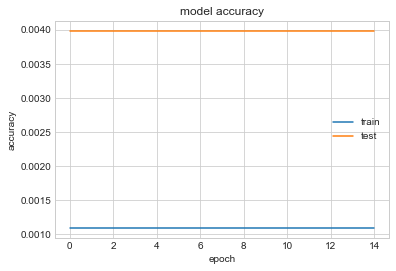

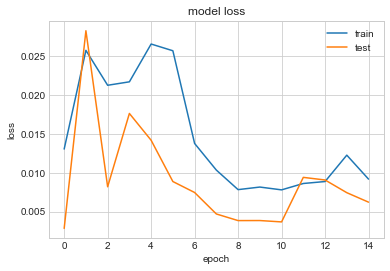

Fitting to PAYX
Epoch 1/15
14/14 - 0s - loss: 0.0139 - accuracy: 7.2307e-04 - val_loss: 0.0077 - val_accuracy: 0.0040
Epoch 2/15
14/14 - 0s - loss: 0.0142 - accuracy: 7.2307e-04 - val_loss: 0.0184 - val_accuracy: 0.0040
Epoch 3/15
14/14 - 0s - loss: 0.0147 - accuracy: 7.2307e-04 - val_loss: 0.0096 - val_accuracy: 0.0040
Epoch 4/15
14/14 - 0s - loss: 0.0104 - accuracy: 7.2307e-04 - val_loss: 0.0038 - val_accuracy: 0.0040
Epoch 5/15
14/14 - 0s - loss: 0.0062 - accuracy: 7.2307e-04 - val_loss: 0.0053 - val_accuracy: 0.0040
Epoch 6/15
14/14 - 0s - loss: 0.0047 - accuracy: 7.2307e-04 - val_loss: 0.0034 - val_accuracy: 0.0040
Epoch 7/15
14/14 - 0s - loss: 0.0052 - accuracy: 7.2307e-04 - val_loss: 0.0033 - val_accuracy: 0.0040
Epoch 8/15
14/14 - 0s - loss: 0.0047 - accuracy: 7.2307e-04 - val_loss: 0.0034 - val_accuracy: 0.0040
Epoch 9/15
14/14 - 0s - loss: 0.0059 - accuracy: 7.2307e-04 - val_loss: 0.0045 - val_accuracy: 0.0040
Epoch 10/15
14/14 - 0s - loss: 0.0069 - accuracy: 7.2307e-04 - val

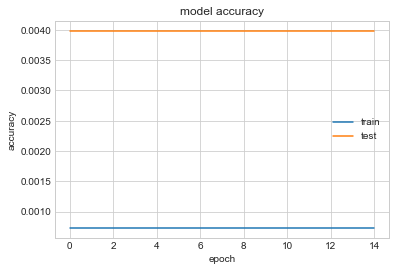

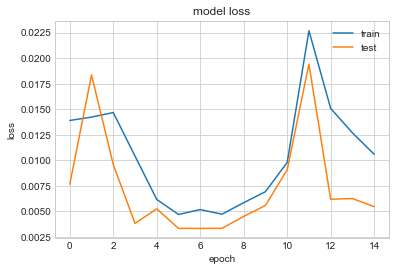

Fitting to SCD
Epoch 1/15
14/14 - 0s - loss: 0.0119 - accuracy: 7.2307e-04 - val_loss: 0.0041 - val_accuracy: 0.0040
Epoch 2/15
14/14 - 0s - loss: 0.0054 - accuracy: 7.2307e-04 - val_loss: 0.0027 - val_accuracy: 0.0040
Epoch 3/15
14/14 - 0s - loss: 0.0047 - accuracy: 7.2307e-04 - val_loss: 0.0016 - val_accuracy: 0.0040
Epoch 4/15
14/14 - 0s - loss: 0.0036 - accuracy: 7.2307e-04 - val_loss: 0.0011 - val_accuracy: 0.0040
Epoch 5/15
14/14 - 0s - loss: 0.0035 - accuracy: 7.2307e-04 - val_loss: 8.6255e-04 - val_accuracy: 0.0040
Epoch 6/15
14/14 - 0s - loss: 0.0036 - accuracy: 7.2307e-04 - val_loss: 8.3583e-04 - val_accuracy: 0.0040
Epoch 7/15
14/14 - 0s - loss: 0.0034 - accuracy: 7.2307e-04 - val_loss: 8.8773e-04 - val_accuracy: 0.0040
Epoch 8/15
14/14 - 0s - loss: 0.0033 - accuracy: 7.2307e-04 - val_loss: 8.4481e-04 - val_accuracy: 0.0040
Epoch 9/15
14/14 - 0s - loss: 0.0033 - accuracy: 7.2307e-04 - val_loss: 8.4752e-04 - val_accuracy: 0.0040
Epoch 10/15
14/14 - 0s - loss: 0.0032 - accurac

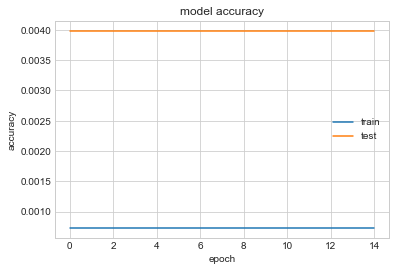

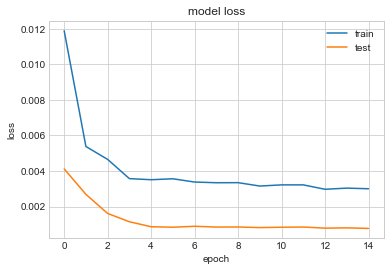

Fitting to SCX
Epoch 1/15
14/14 - 0s - loss: 0.0035 - accuracy: 7.2307e-04 - val_loss: 0.0023 - val_accuracy: 0.0060
Epoch 2/15
14/14 - 0s - loss: 0.0033 - accuracy: 7.2307e-04 - val_loss: 0.0022 - val_accuracy: 0.0060
Epoch 3/15
14/14 - 0s - loss: 0.0032 - accuracy: 7.2307e-04 - val_loss: 0.0020 - val_accuracy: 0.0060
Epoch 4/15
14/14 - 0s - loss: 0.0031 - accuracy: 7.2307e-04 - val_loss: 0.0024 - val_accuracy: 0.0060
Epoch 5/15
14/14 - 0s - loss: 0.0032 - accuracy: 7.2307e-04 - val_loss: 0.0021 - val_accuracy: 0.0060
Epoch 6/15
14/14 - 0s - loss: 0.0029 - accuracy: 7.2307e-04 - val_loss: 0.0020 - val_accuracy: 0.0060
Epoch 7/15
14/14 - 0s - loss: 0.0026 - accuracy: 7.2307e-04 - val_loss: 0.0021 - val_accuracy: 0.0060
Epoch 8/15
14/14 - 0s - loss: 0.0026 - accuracy: 7.2307e-04 - val_loss: 0.0021 - val_accuracy: 0.0060
Epoch 9/15
14/14 - 0s - loss: 0.0025 - accuracy: 7.2307e-04 - val_loss: 0.0021 - val_accuracy: 0.0060
Epoch 10/15
14/14 - 0s - loss: 0.0024 - accuracy: 7.2307e-04 - val_

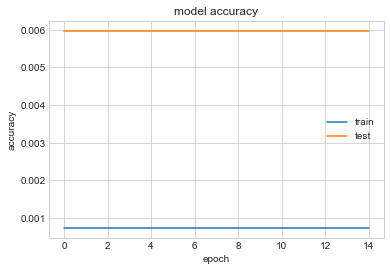

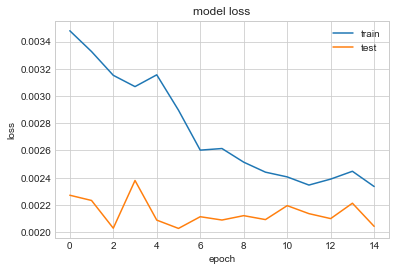

In [22]:
# The LSTM architecture
regressor2 = Sequential()
# First LSTM layer with Dropout regularisation
regressor2.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor2.add(Dropout(0.2))
# Second LSTM layer
regressor2.add(LSTM(units=50, return_sequences=True))
regressor2.add(Dropout(0.5))
# Third LSTM layer
regressor2.add(LSTM(units=50, return_sequences=True))
regressor2.add(Dropout(0.5))
# Fourth LSTM layer
regressor2.add(LSTM(units=50))
regressor2.add(Dropout(0.5))
# The output layer
regressor2.add(Dense(units=1))

opt = tf.keras.optimizers.RMSprop(learning_rate=0.01)
opt2 = keras.optimizers.Adam(learning_rate=0.01)

# Compiling the RNN
regressor2.compile(optimizer=opt2, loss='mean_squared_error', metrics=['accuracy'])

regressor2.summary()

my_callbacks = [keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0,  
          write_graph=True, write_images=True)
]

# Fitting to the training set
for i in tickers2:
    print("Fitting to", i)
    results = regressor2.fit(trainset[i]["X"], trainset[i]["y"], epochs=15, batch_size=200, validation_data=(testset[i]["X"], testset[i]["y"]), verbose=2, shuffle=False)

    # evaluate the keras model
    _, accuracy = regressor2.evaluate(trainset[i]["X"], trainset[i]["y"])
    print('Accuracy: %.2f' % (accuracy*100))
    
    # summarize history for accuracy
    plt.plot(results.history['accuracy'])
    plt.plot(results.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'])
    plt.show()
    
    # summarize history for loss
    plt.plot(results.history['loss'])
    plt.plot(results.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'])
    plt.show()

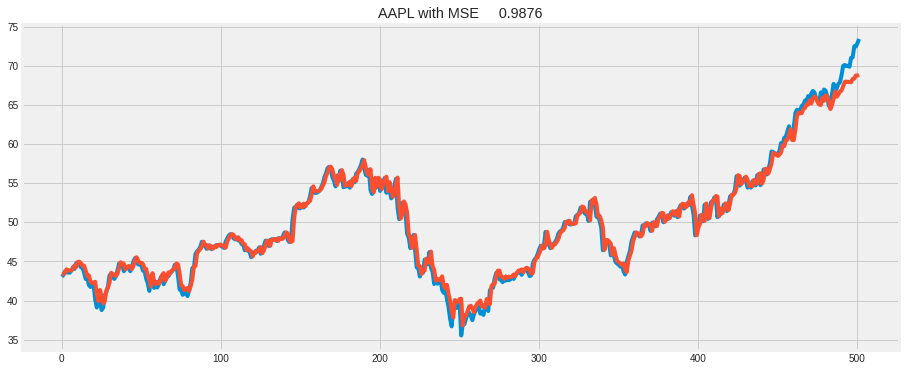

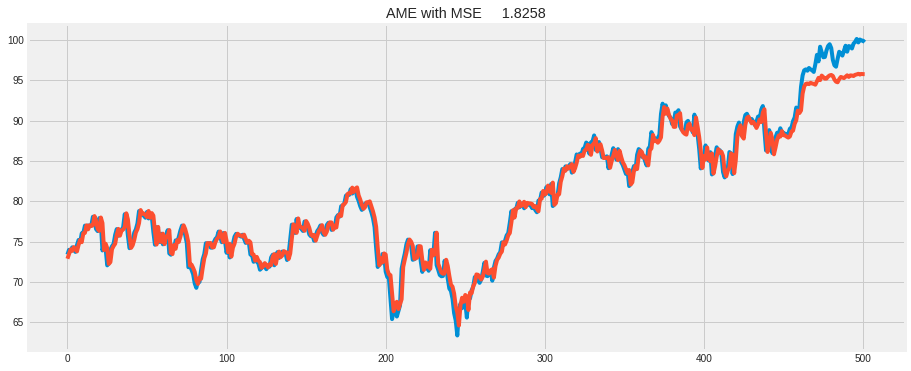

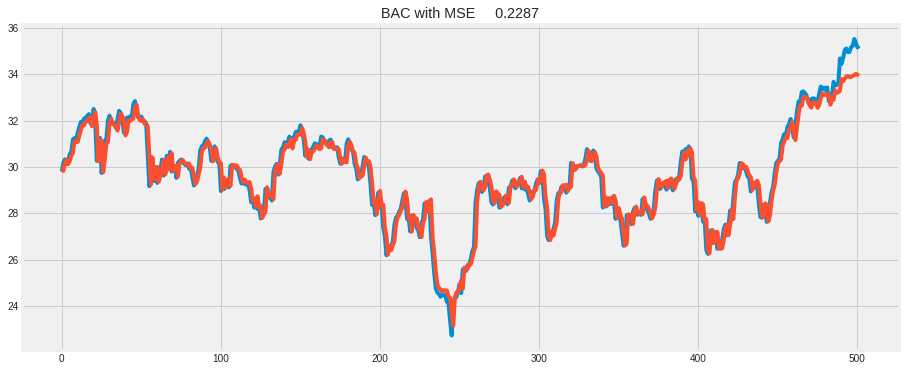

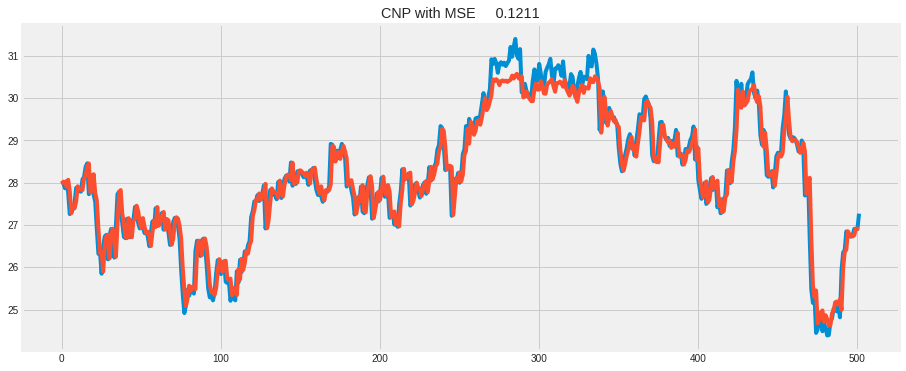

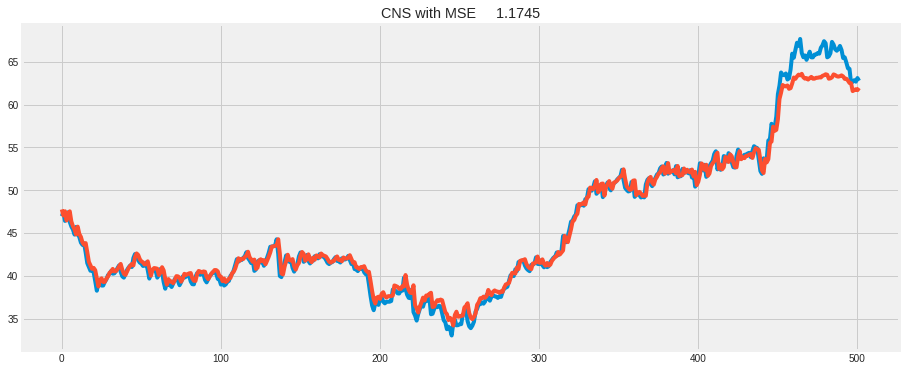

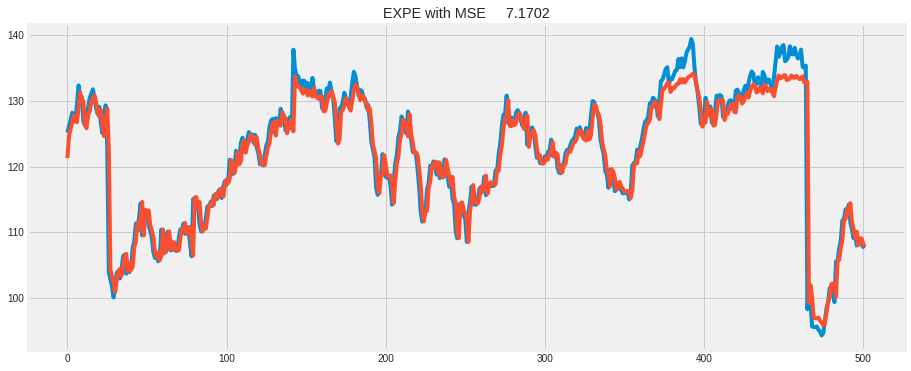

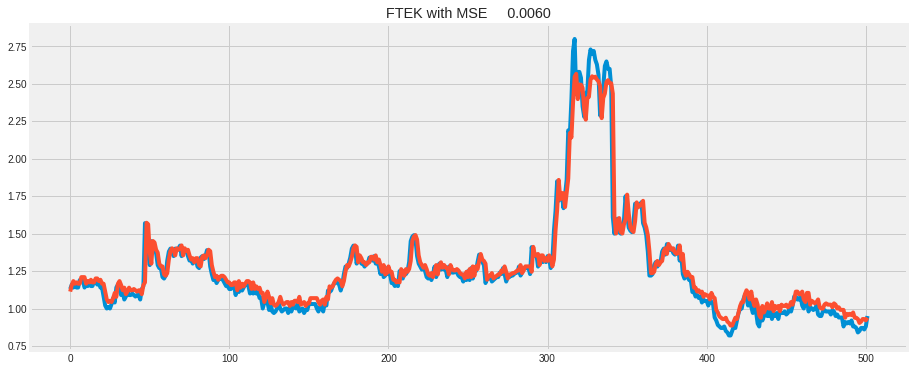

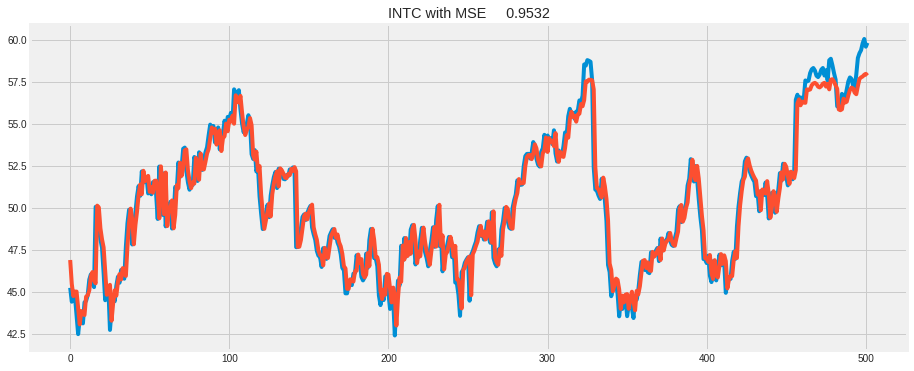

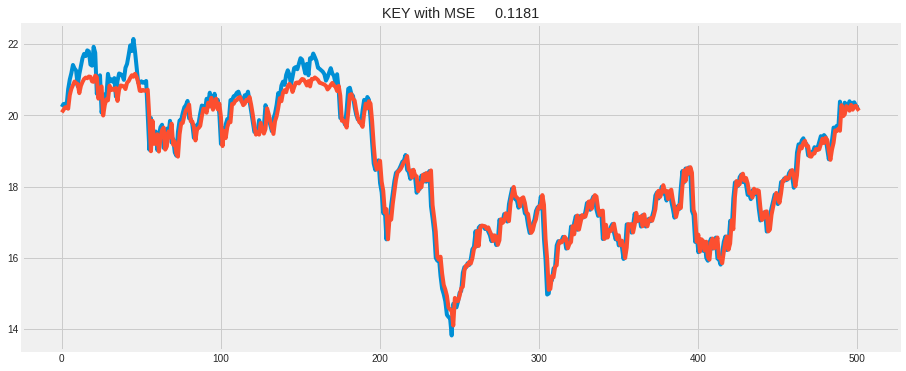

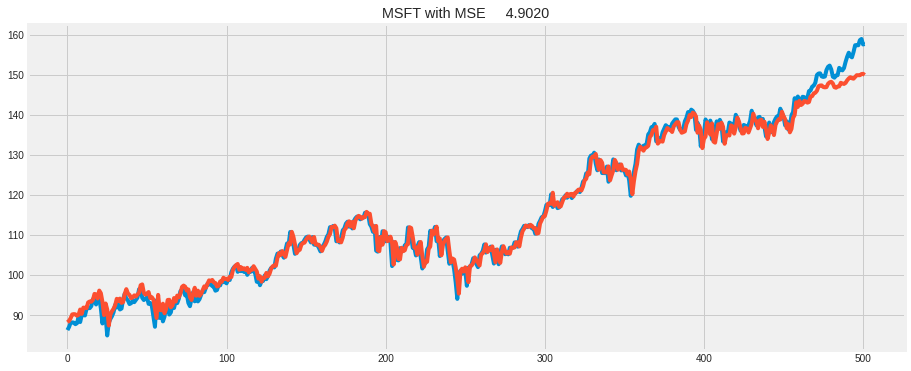

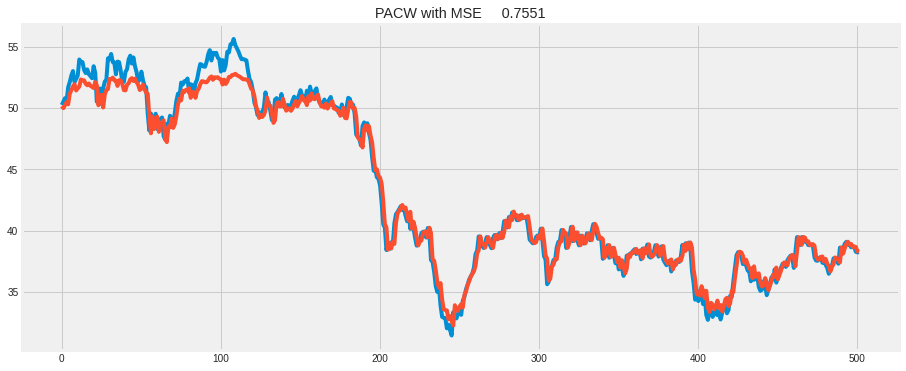

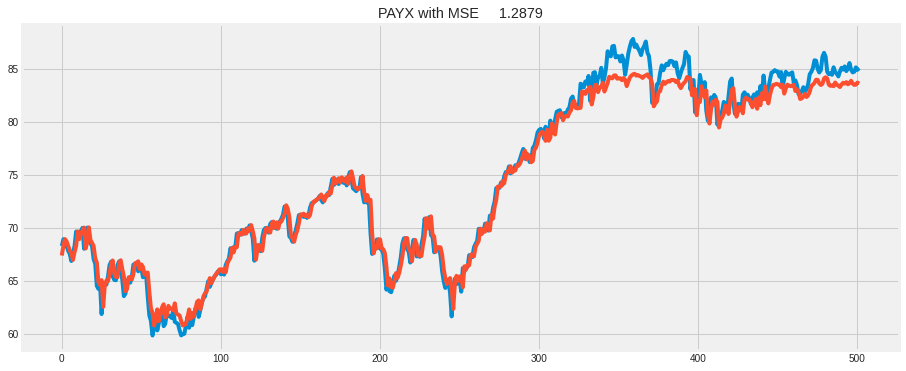

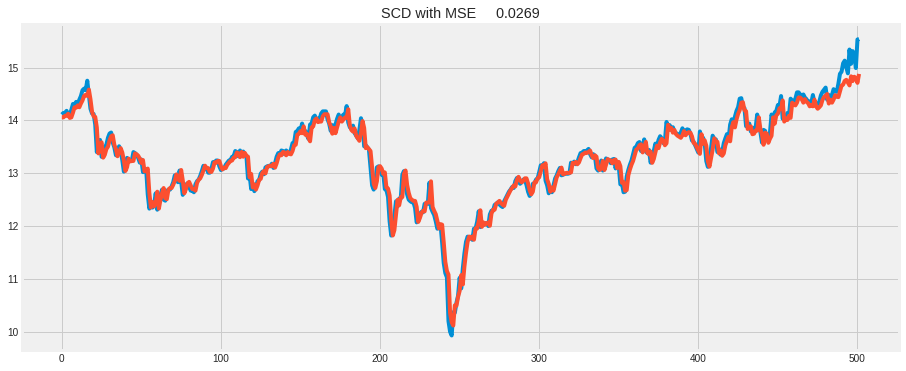

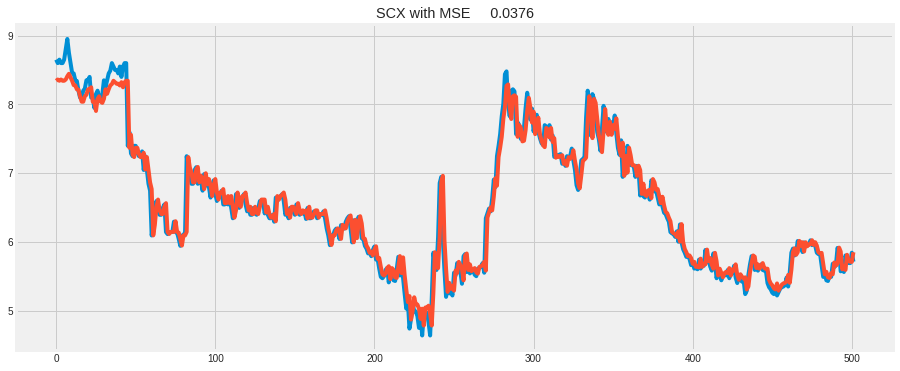

In [ ]:
pred_result2 = {}
for i in tickers2:
    y_true2 = scaler[i].inverse_transform(testset[i]["y"].reshape(-1,1))
    y_pred2 = scaler[i].inverse_transform(regressor2.predict(testset[i]["X"]))
    MSE = mean_squared_error(y_true2, y_pred2)
    pred_result2[i] = {}
    pred_result2[i]["True"] = y_true2
    pred_result2[i]["Pred"] = y_pred2
    pred = pd.DataFrame(y_pred2, columns=['Pred_'+i])
    true = pd.DataFrame(y_true2, columns=['True_'+i])
    result = pd.concat([pred, true], axis=1)
    result = result.to_csv('results_pred_'+i+'.csv')
    plt.figure(figsize=(14,6))
    plt.title("{} with MSE {:10.4f}".format(i,MSE))
    plt.plot(y_true2)
    plt.plot(y_pred2)